### In this notebook I analyse all species included in the Bufo libraries . . . . 

#### They include:

- B. variabilis
- B. viridis
- B. Belearicus
- B. turanensis
- B. shaartusiensis
- B. latastii
- B. pewzowi

- B. bufo

- Pelobates fuscus






In [3]:
%matplotlib inline
import os
import wget ## used "sudo pip install wget" in command line to get package.
import Incremental_U as IncU ## Get this sorted
import Incremental_C as IncC
import Incremental_Pop_mod as IncPop
import MISC_RAD_tools as MISC
import pprint
import subprocess

In [4]:
%load_ext rpy2.ipython

## Variabilis

2 families, one with 4, one with 6 offspring. 


### Popmap

Th1F1female     F  
Th1F2   F  
Th1F2xTh1M2_1M  OM  
Th1F2xTh1M2_2F  OF  
Th1F2xTh1M2_3F  OF  
Th1F2xTh1M2_4M  OM  
Th1F2xTh1M2_5   U         
Th1F2xTh1M2_7F  OF  
Th1M1male       M  
Th1M1xTh1F1_22F OF  
Th1M1xTh1F1_23M OM  
Th1M1xTh1F1_24M OM  
Th1M1xTh1F1_27M OM  
Th1M2   M  

### Populations command
populations -b 1 -P ./ -M Variabilis/popmap.txt -r 0.75 -p 4 --min_maf 0.05 --max_obs_het 0.75 --vcf -t 10 > Variabilis/Populations.log 2>&1 &

In [3]:
wd = "/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/"

### First do a quick PCA to see how the samples look. . . . 

In [9]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis//batch_1_altered_adegenet_plink-temporary.fam
written.
9228 variants loaded from .bim file.
14 people (0 males, 0 females, 14 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie

In [369]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



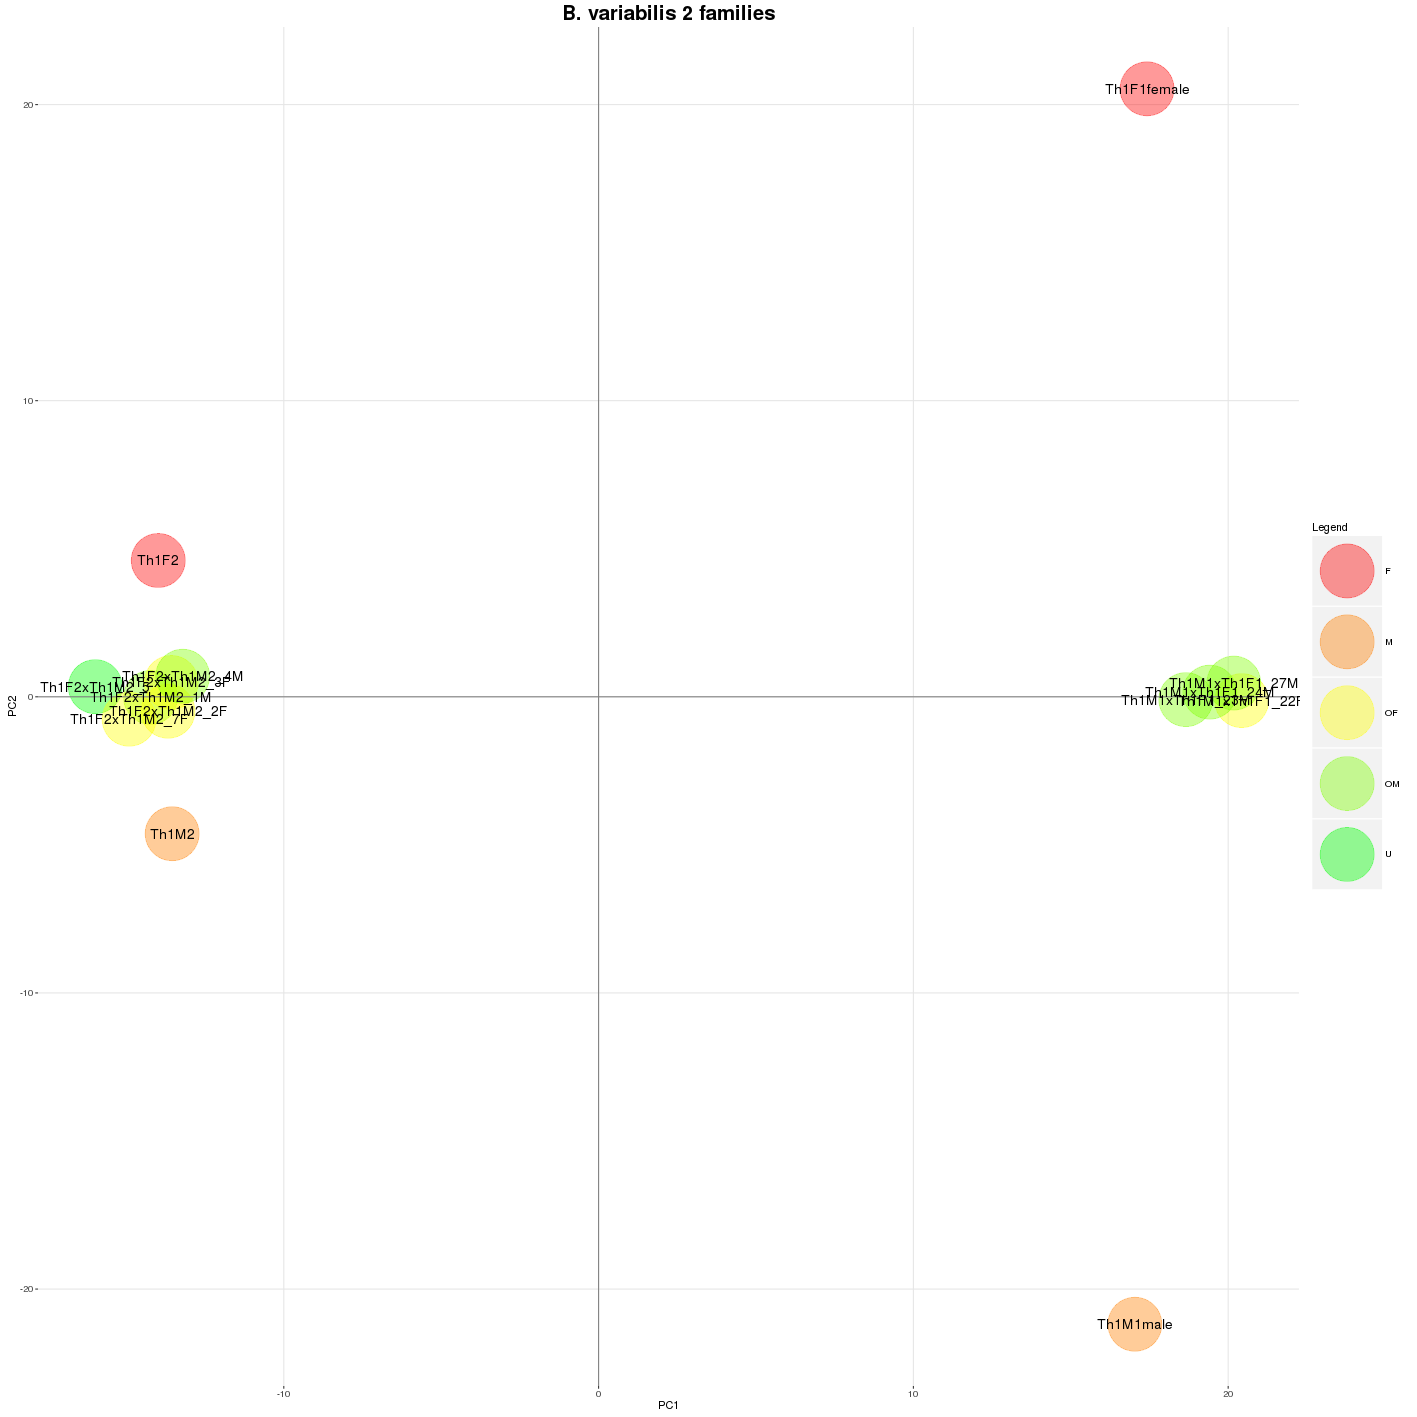

In [370]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. variabilis 2 families", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

### Now look for sex linked markers using just male and female assignments, not within families. 

Only worth using Method 2 - it is less prone to false positives.

In [22]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 10 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [23]:
B_var_XYset, B_var_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 9228
Number of samples = 14
Number of loci with too few samples = 4995
Number of loci with low MAF = 0
Number of loci with enough data = 4152
Number of putative X linked snps = 23
Number of putative X linked tags = 23
Number of putative Z linked markers = 30
Number of putative Z linked tags = 30

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis

 ## After merging tags accross methods ## 

Final number of XY tags = 23
Final number of ZW tags = 30


### Now try just family 2, with very strict parameters

In [297]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1/popcodes.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 1
hom = 1

Fam2_XY, Fam2_ZW = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom)

Number of good loci = 2200

N loci suitable for XY testing: 1093
N XY test loci with enough heterozygous males: 290
N loci that fit the specified XY criteria: 163

N loci suitable for ZW testing: 1107
N ZW test loci with enough heterozygous females: 559
N loci that fit the specified ZW criteria: 17


### So this result suggests XY! Does this make sense?

How do all the samples fall on a PCA and heatmap using these loci??

In [299]:
Fam2_XY = [i.split("_")[0] for i in Fam2_XY]


In [301]:
MISC.filter_vcf_tag_ID_only(vcf, Fam2_XY, "batch_1_only.vcf")

In [302]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1_only.vcf > $wd/batch_1_altered_adegenetXY.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenetXY.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plinkXY


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1//batch_1_altered_adegenet_plinkXY.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1//batch_1_altered_adegenet_plinkXY
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1//batch_1_altered_adegenetXY.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1//batch_1_altered_adegenet_plinkXY-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1//batch_1_altered_adegenet_plinkXY-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1//batch_1_altered_ade

In [304]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_variabilis/Populations_variabilis_Fam1/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plinkXY.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



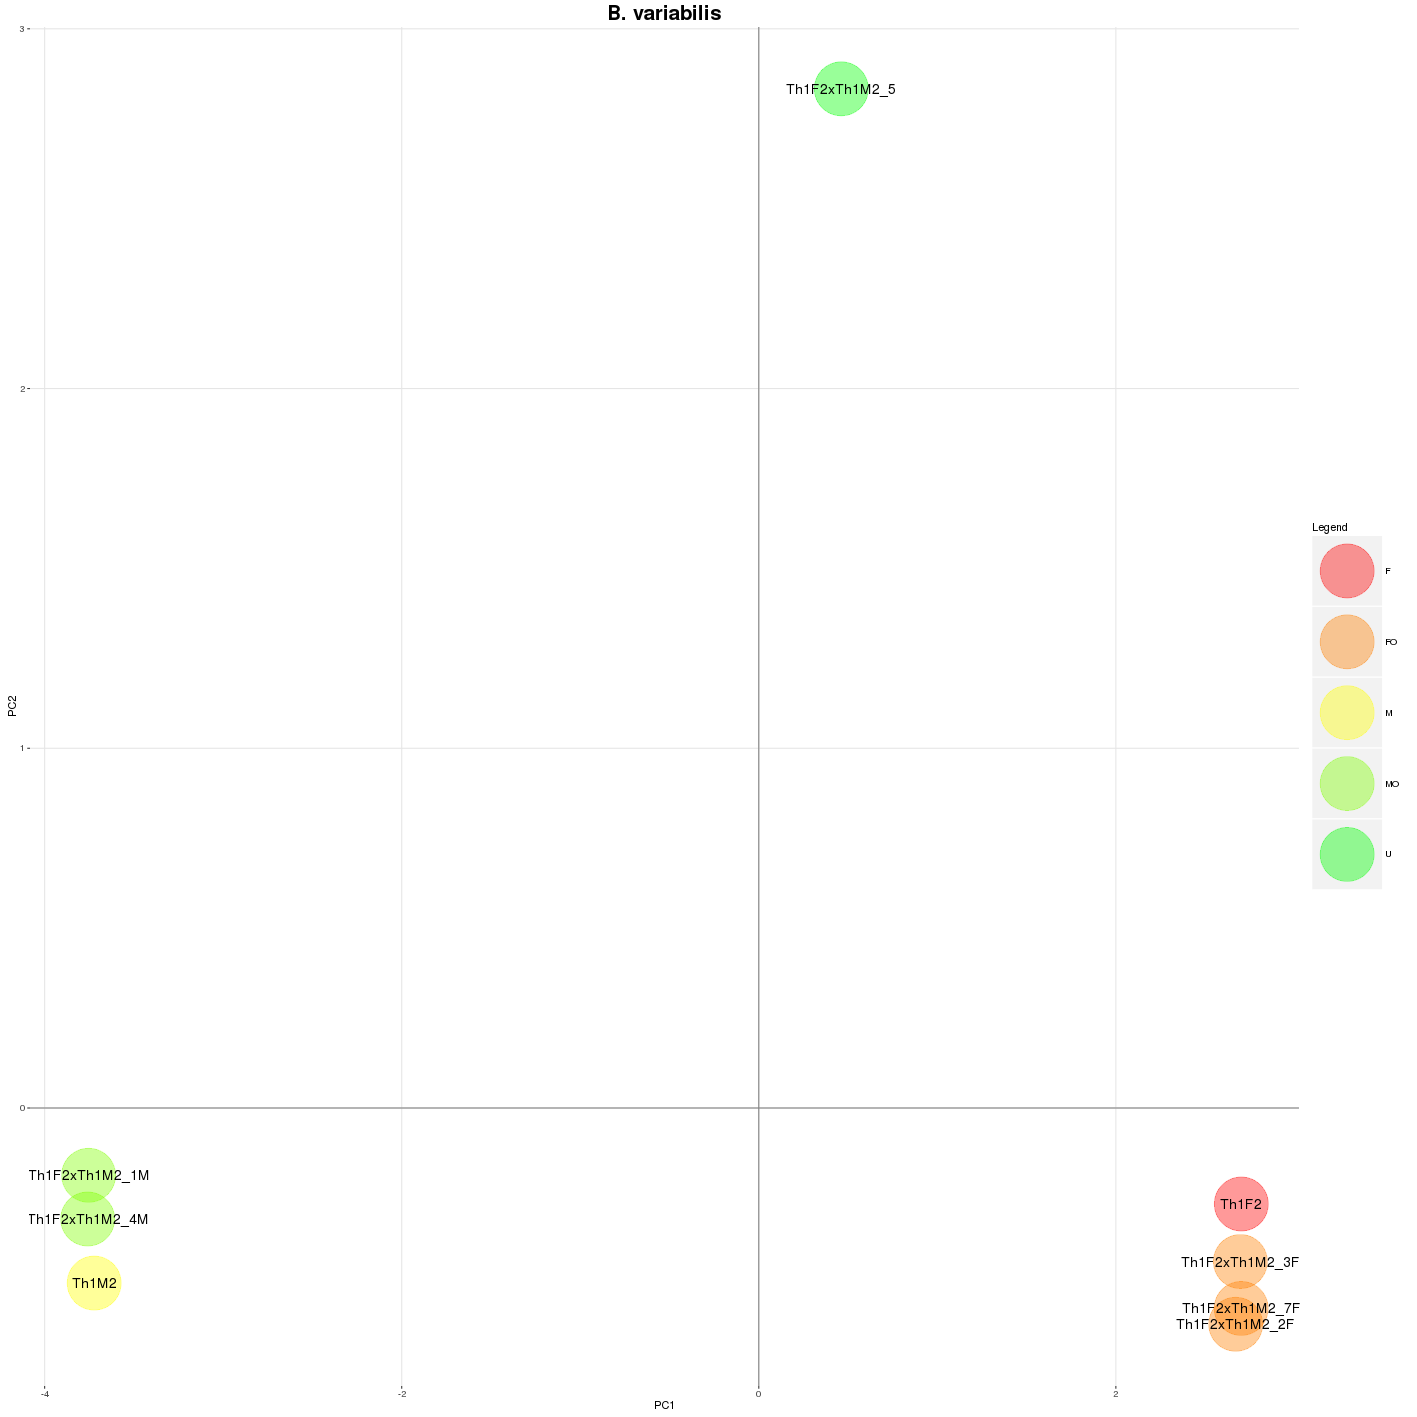

In [305]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popcodes.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. variabilis", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

I don't really trust it - the fact that the unnassigned sample doesn't fall with either group suggests to me that these loci are not sex-linked but just a result of the skew in males and females. 

### So there is no real chance here - there are just not enough samples per family.

# Bufo bufo

###Family 1. 

- Mother
- Father
- 16 Female offspring
- 5 Male offspring

In [24]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink-temporary.fam
written.
3361 variants loaded from .bim file.
22 people (0 mal

In [25]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



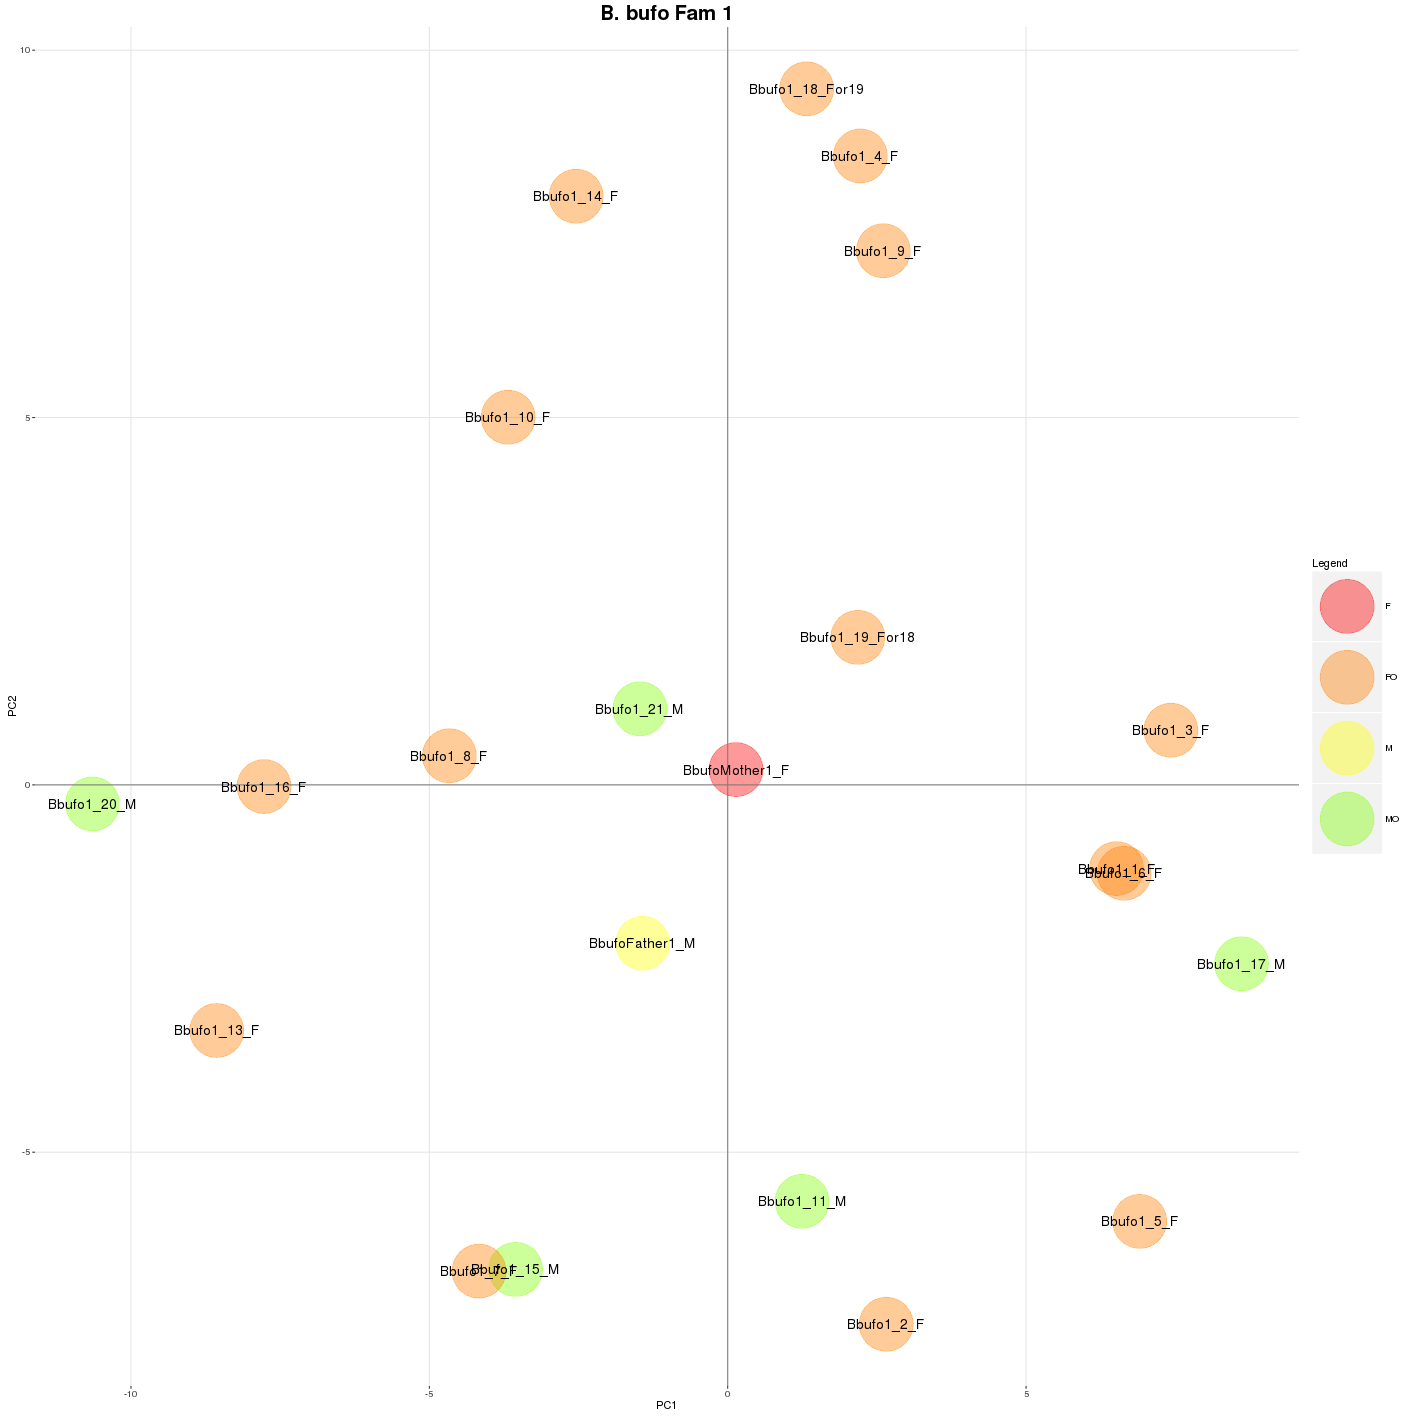

In [27]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_Bbufo_1.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. bufo Fam 1", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [5]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/popmap_Bbufo_1.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.6
hom = 1



In [6]:
Fam1_XY, Fam1_ZW = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom   )

Number of good loci = 2076

N loci suitable for XY testing: 1105
N XY test loci with enough heterozygous males: 364
N loci that fit the specified XY criteria: 0

N loci suitable for ZW testing: 971
N ZW test loci with enough heterozygous females: 970
N loci that fit the specified ZW criteria: 2


In [308]:
Fam1_ZW = [i.split("_")[0] for i in Fam1_ZW]

MISC.filter_vcf_tag_ID_only(vcf, Fam1_ZW, "batch_1_ZW_only.vcf")

In [313]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1_ZW_only.vcf > $wd/batch_1_altered_adegenet_ZW.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet_ZW.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink_ZW


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink_ZW.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink_ZW
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_ZW.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink_ZW-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink_ZW-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_altered_adegenet_plink_ZW-temporary.fam
written.
17 variants loaded from .bim file.


In [314]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink_ZW.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



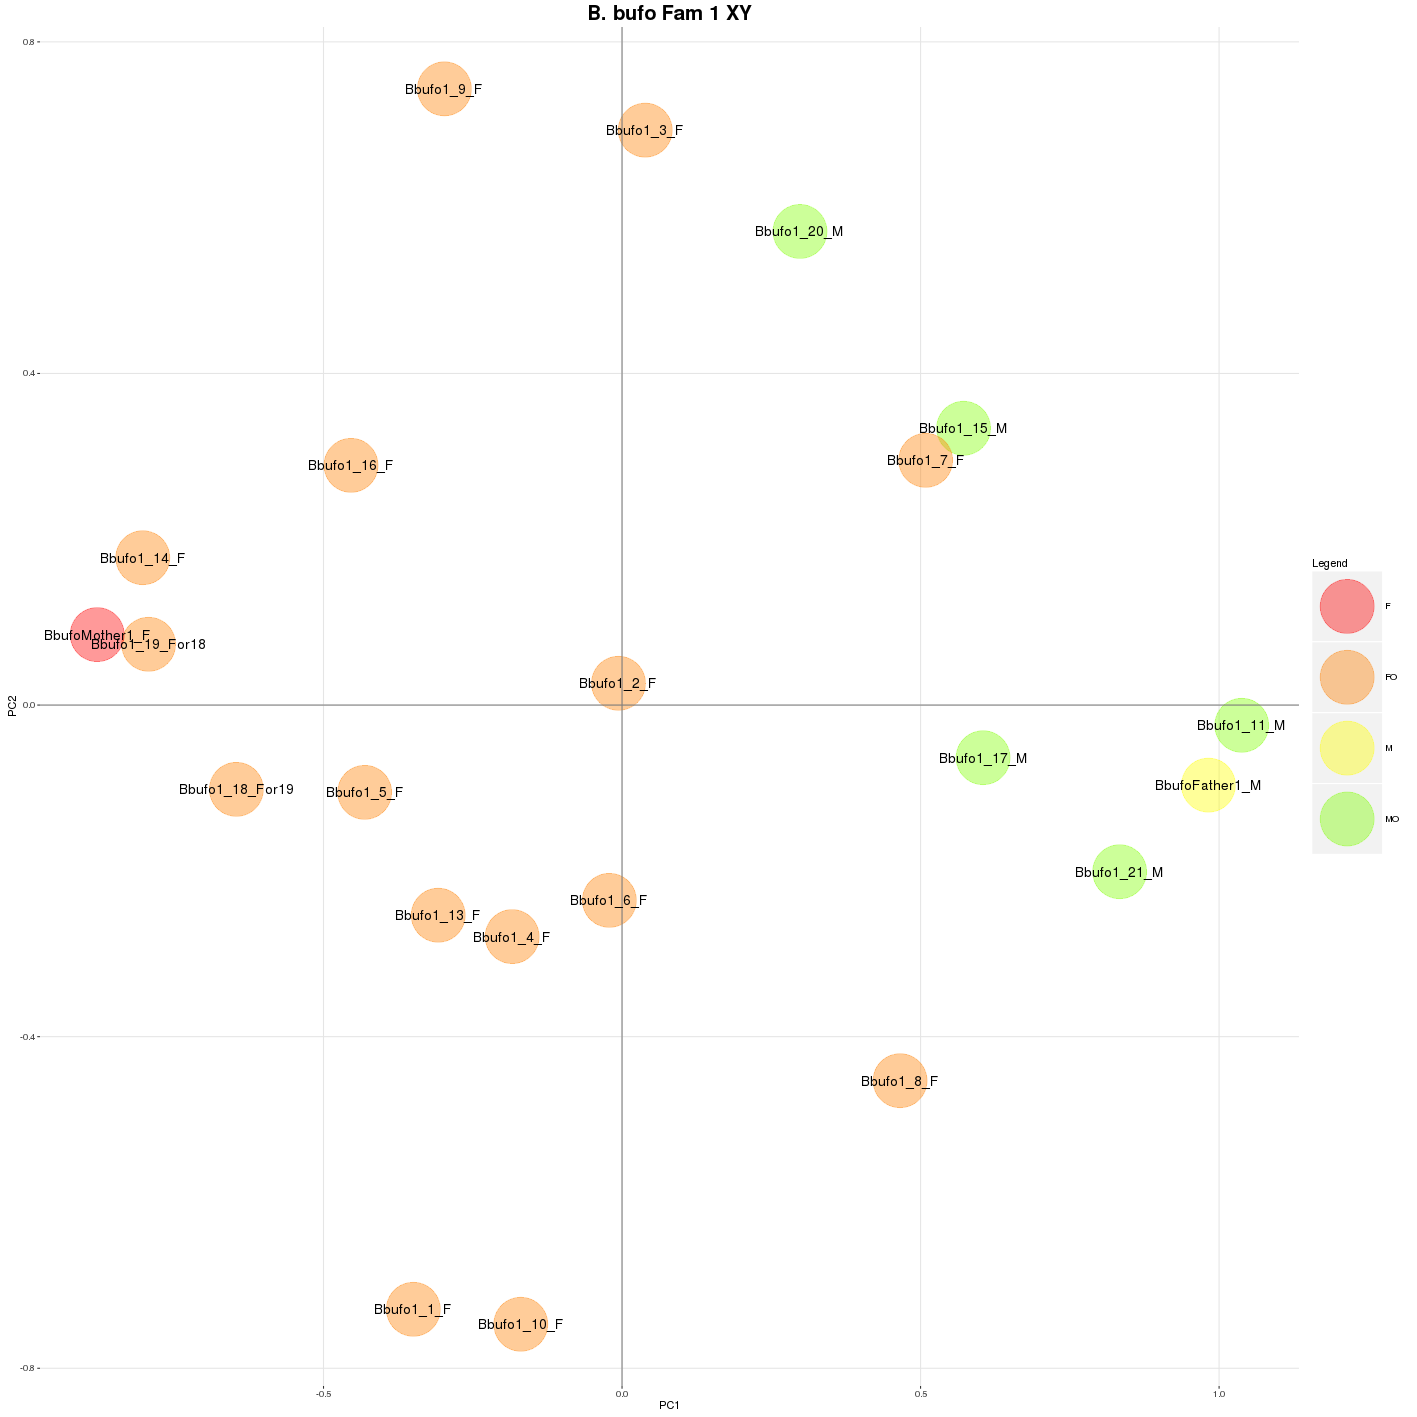

In [312]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_Bbufo_1.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. bufo Fam 1 XY", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So I am really not very confiedent about the sex assignments here. . . So lets try the sex-blind approach and see what happens. . . 

## ZW first

In [322]:
import vcf

Male = "BbufoFather1_M"
Female = "BbufoMother1_F"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1.vcf.altered"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Female: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Male: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        #print record
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



3361 1142


In [323]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_altered_adegenet_filtered_loci_ZW.vcf")

In [325]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/  ## just change this line

sed 's/_/-/g' $wd/batch_1_altered_adegenet_filtered_loci_ZW.vcf > $wd/batch_1_altered_adegenet2_filtered_loci_ZW.vcf

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet2_filtered_loci_ZW.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet2_filtered_loci_ZW


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_ZW.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_ZW
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_ZW.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_ZW-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_ZW-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_

In [326]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet2_filtered_loci_ZW.raw  $wd/batch_1_filtered_heatmap_input_ZW


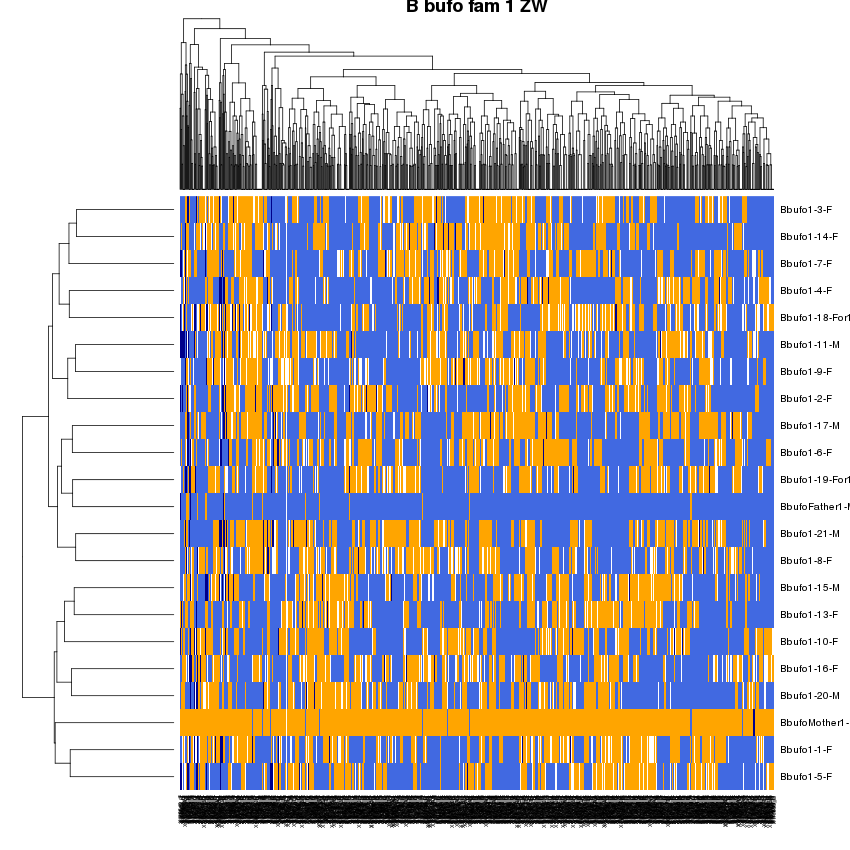

In [327]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_filtered_heatmap_input_ZW.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B bufo fam 1 ZW")

### Ok, nothing, now try XY . . . 

In [328]:
import vcf

Male = "BbufoFather1_M"
Female = "BbufoMother1_F"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1.vcf.altered"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Male: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Female: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        #print record
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



3361 1309


In [329]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_altered_adegenet_filtered_loci_XY.vcf")

In [330]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/  ## just change this line

sed 's/_/-/g' $wd/batch_1_altered_adegenet_filtered_loci_XY.vcf > $wd/batch_1_altered_adegenet2_filtered_loci_XY.vcf

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet2_filtered_loci_XY.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet2_filtered_loci_XY


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_XY.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_XY
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_XY.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_XY-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_loci_XY-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1//batch_1_altered_adegenet2_filtered_

In [331]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet2_filtered_loci_XY.raw  $wd/batch_1_filtered_heatmap_input_XY


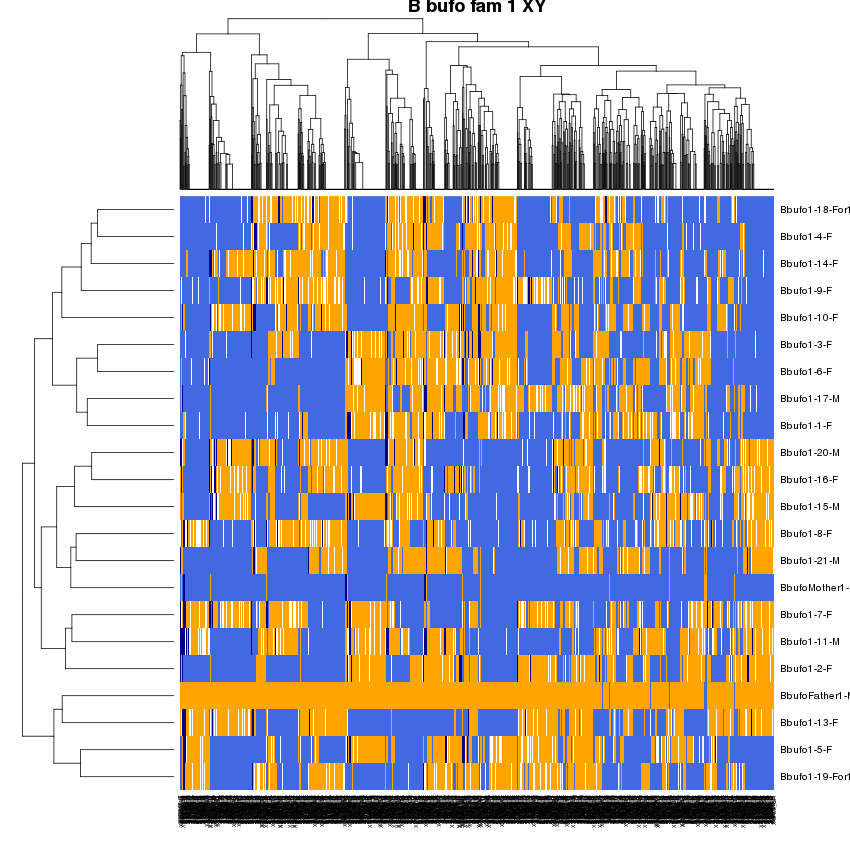

In [332]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1_filtered_heatmap_input_XY.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B bufo fam 1 XY")

It looks much more like some thing is going on here, and there are definitely chunks of loci that could be sex linked, but it is difficult to work out which ones and which way....


One feature that might help is to look for both XY and X-speicific SNPs in the same sample set. . . I.e. for a block of loci which are het in males and hom in females, and where the father is het and the mother is hom, there should be another block, for exactly the same samples, where the father is homozygous, the mother is heterozygous and the mother is HOMOZYGOUS - this last part is the potentially defining feature. 

Here, I can see a block of loci, to the far right. All males are heterozygous in this block, but also so are some assigned as females. However there is also a set of loci, almost exactly in the middle, where almost all females are het and all males are hom, plus some females, Importantly the blocks of samples these loci are the same as the block on the right, and more importantly, the Mother is homozygous here - so these loci fit the X-specific pattern!

So I think what is going on here is that there are some males that have been wrongly assigned as females and this screws up the tests for the sex linked markers. . . . 

So now I will re-assign males and females and run the SLM tests again, to see if there is an improvement in the number of SLMs found. . . 

In [336]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam1/popmap_Bbufo_1_reassigned.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.6
hom = 1

Fam1_XY_reassigned, Fam1_ZW_reassigned = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom   )

Number of good loci = 2076

N loci suitable for XY testing: 1105
N XY test loci with enough heterozygous males: 117
N loci that fit the specified XY criteria: 51

N loci suitable for ZW testing: 971
N ZW test loci with enough heterozygous females: 933
N loci that fit the specified ZW criteria: 0


### So the answer seems to be yes - there are more SLMs identified with these assignments . . 

So this would explain the skew of males and females, and indeed Matthias mentioned in the sample information that the histological sexing of these samples might not be 100% accurate. . . 


So lets see how things go for Family 2. 

##Family 2

- Mother
- Father
- 3 Male offspring
- 11 Female offspring

In [46]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_altered_adegenet_plink-temporary.fam
written.
1209 variants loaded from .bim file.
16 people (0 mal

In [47]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



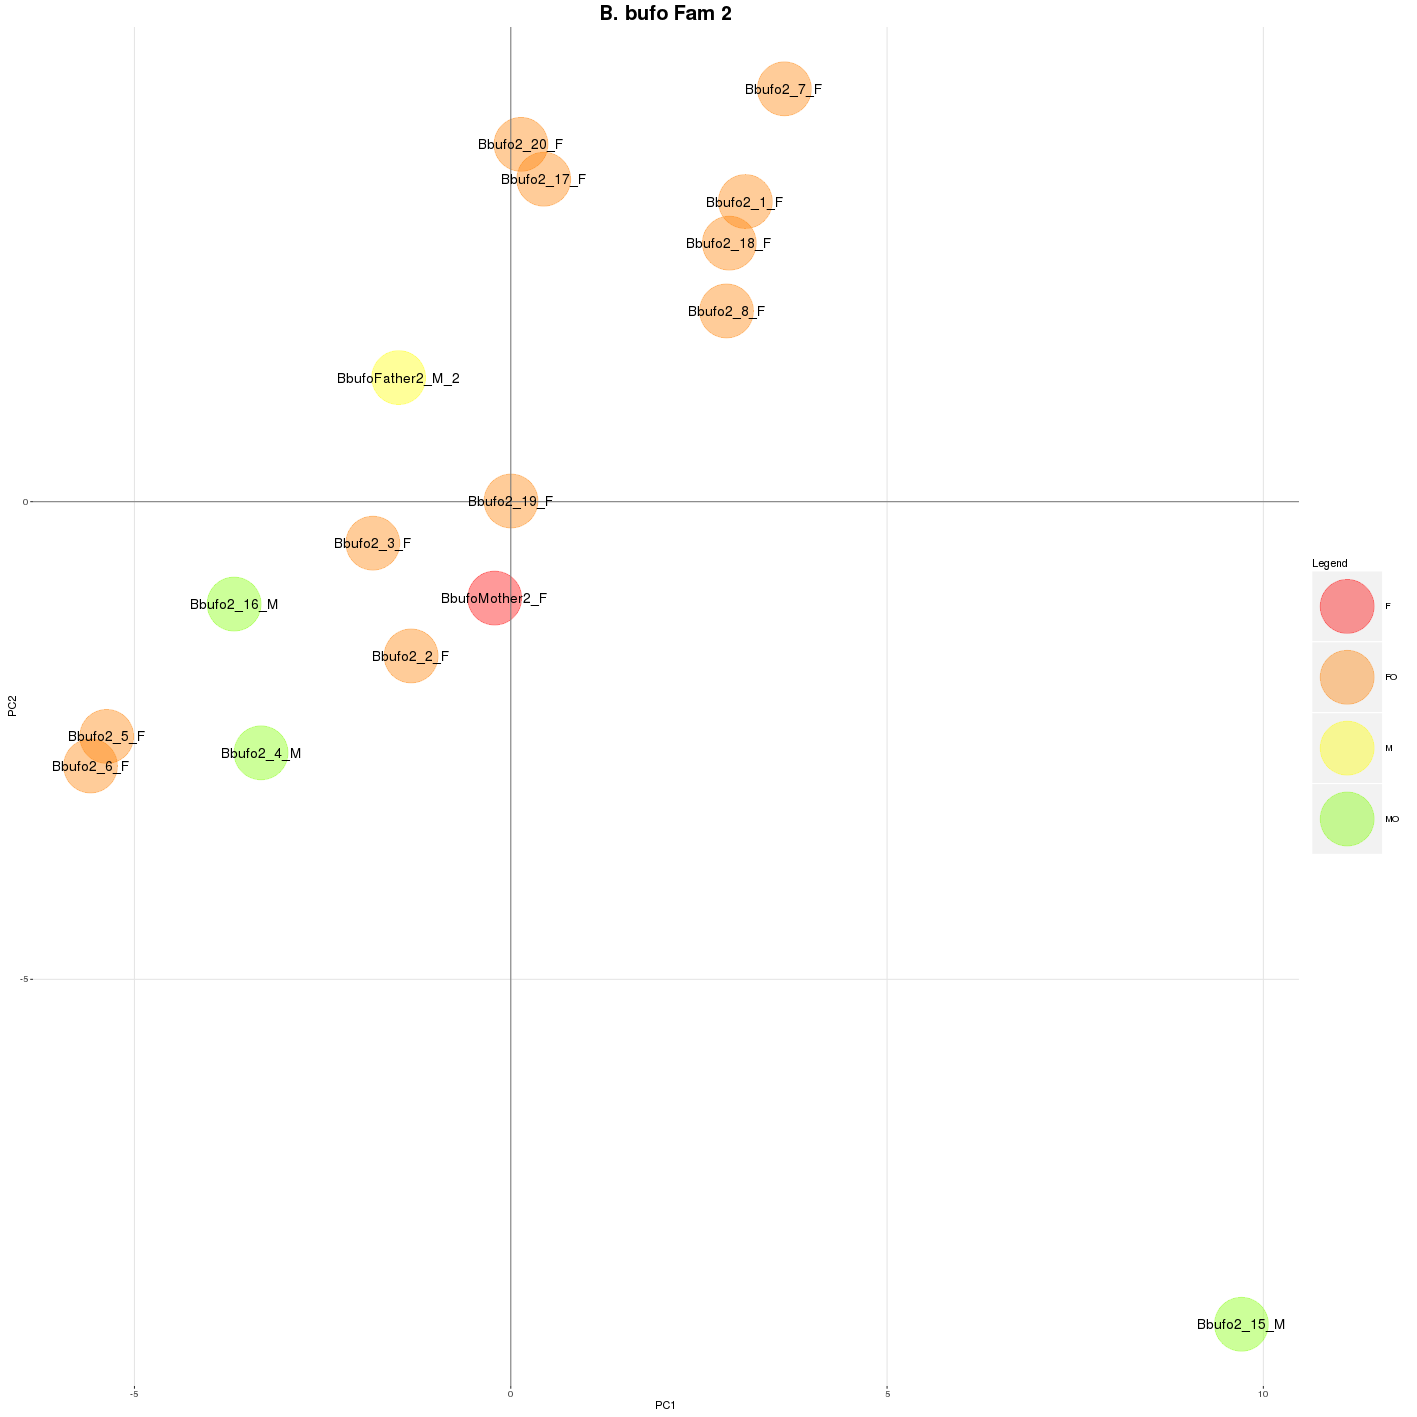

In [48]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_Bbufo_2.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. bufo Fam 2", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [15]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/popmap_Bbufo_2.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.5
hom = 1


In [16]:
Fam2_XY, Fam2_ZW = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom)

Number of good loci = 727

N loci suitable for XY testing: 379
N XY test loci with enough heterozygous males: 151
N loci that fit the specified XY criteria: 0

N loci suitable for ZW testing: 348
N ZW test loci with enough heterozygous females: 346
N loci that fit the specified ZW criteria: 22


In [59]:
from collections import Counter

allZW = Fam1_ZW + Fam2_ZW

Counter(allZW)



Counter({'163983_15250394': 1, '138027_12836507': 1, '120654_11220777': 1, '176041_16371762': 1, '133970_12459140': 1, '171891_15985843': 1, '171391_15939342': 1, '116679_10851133': 1, '183780_17091538': 1, '119259_11091062': 1, '180394_16776558': 1, '122274_11371410': 1, '137121_12752220': 1, '189578_17630705': 1, '120314_11189179': 1, '176127_16379728': 1, '154044_14326052': 1, '162081_15073475': 1, '164595_15307323': 1, '149590_13911848': 1, '183780_17091522': 1, '161578_15026705': 1, '157514_14648777': 1, '131302_12211041': 1, '152222_14156645': 1, '120314_11189125': 1})

### Suggests ZW system, but so few males is likely to be a problem - i.e. could easily miss heterozygous loci with such a skew so ZW false positive would be expected with  such a sample set.

so lets try the sex-blind approach again, with ZW and XY

### ZW

In [339]:
import vcf

Male = "BbufoFather2_M_2"
Female = "BbufoMother2_F"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1.vcf.altered"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Female: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Male: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        #print record
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



1209 412


In [348]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_altered_adegenet_filtered_loci_ZW.vcf")

In [352]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/  ## just change this line

sed 's/_/-/g' $wd/batch_1_altered_adegenet_filtered_loci_ZW.vcf > $wd/batch_1_altered_adegenet2_filtered_loci_ZW.vcf

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet2_filtered_loci_ZW.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet2_filtered_loci_ZW


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_ZW.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_ZW
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_ZW.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_ZW-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_ZW-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_

In [353]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet2_filtered_loci_ZW.raw  $wd/batch_1_filtered_heatmap_input_ZW


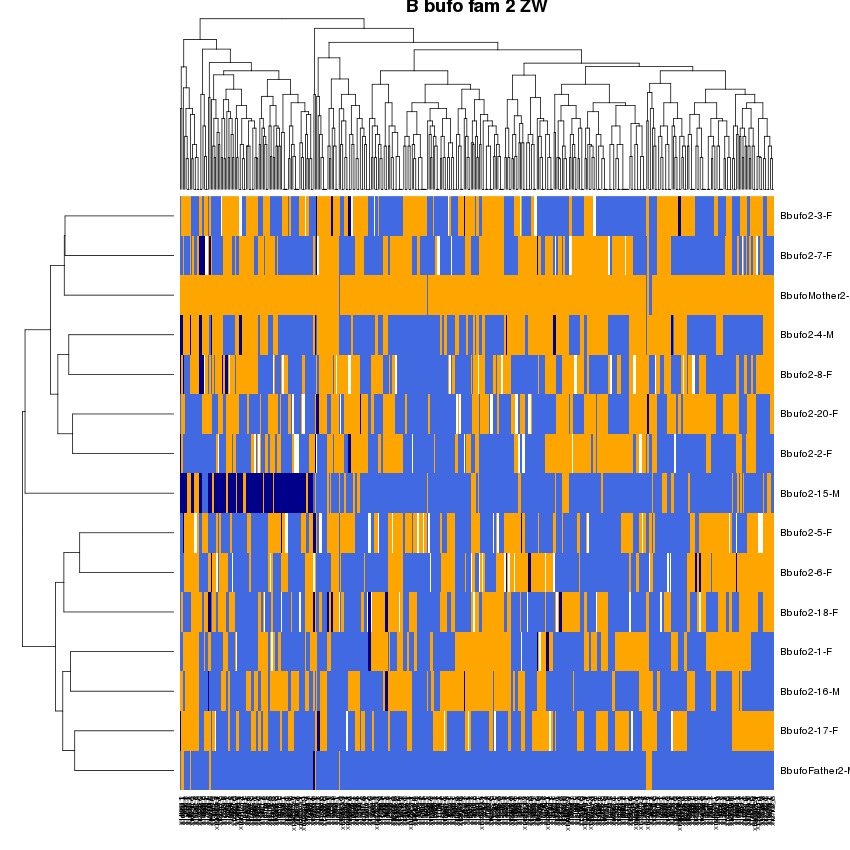

In [355]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_filtered_heatmap_input_ZW.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B bufo fam 2 ZW")

##  XY

In [356]:
import vcf

Male = "BbufoFather2_M_2"
Female = "BbufoMother2_F"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1.vcf.altered"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Male: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Female: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        #print record
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



1209 477


In [358]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_altered_adegenet_filtered_loci_XY.vcf")

In [359]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/  ## just change this line

sed 's/_/-/g' $wd/batch_1_altered_adegenet_filtered_loci_XY.vcf > $wd/batch_1_altered_adegenet2_filtered_loci_XY.vcf

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet2_filtered_loci_XY.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet2_filtered_loci_XY


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_XY.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_XY
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_XY.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_XY-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_loci_XY-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2//batch_1_altered_adegenet2_filtered_

In [361]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet2_filtered_loci_XY.raw  $wd/batch_1_filtered_heatmap_input_XY


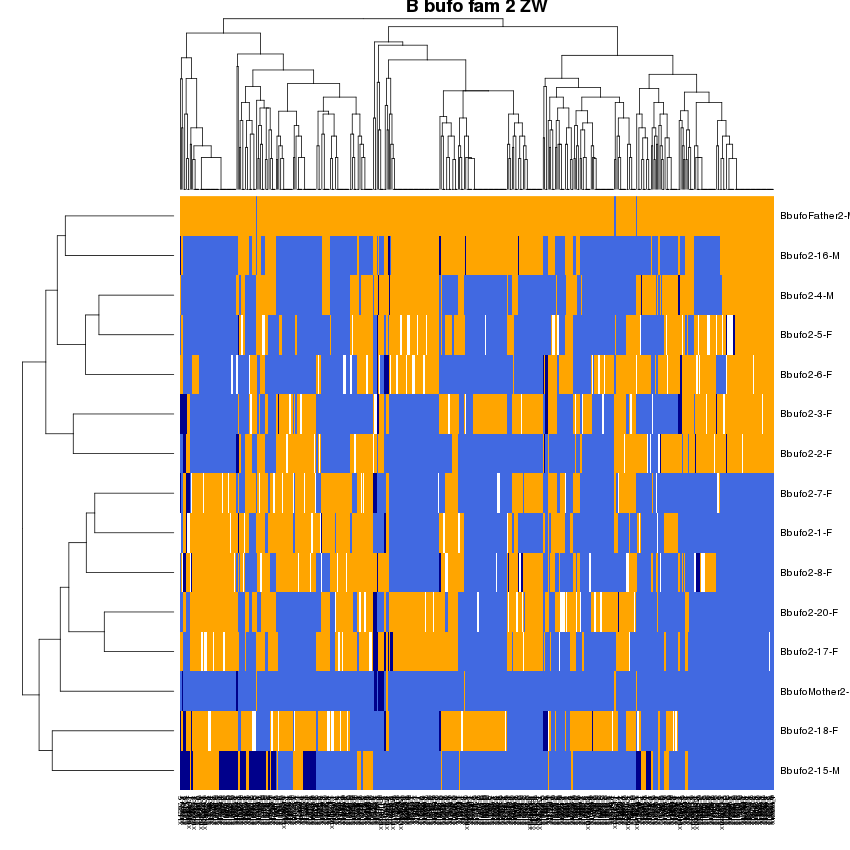

In [363]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1_filtered_heatmap_input_XY.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B bufo fam 2 ZW")

### Yep, again it looks like the sex assignments here are very wrong. . . reassigning and re-running SLM tests...

In [372]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_Bufo_Fam2/popmap_Bbufo_2_reassigned.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.6
hom = 0.8

Fam2_XY_reassigned, Fam2_ZW_reassigned = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom   )

Number of good loci = 781

N loci suitable for XY testing: 414
N XY test loci with enough heterozygous males: 137
N loci that fit the specified XY criteria: 47

N loci suitable for ZW testing: 367
N ZW test loci with enough heterozygous females: 315
N loci that fit the specified ZW criteria: 1


### Ok, so XY wins again. . . are there shared loci across the families?

<matplotlib_venn._common.VennDiagram instance at 0x7f42e853fcf8>

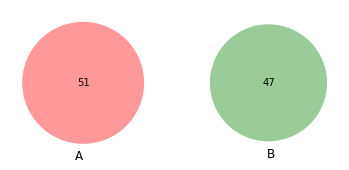

In [368]:
venn2((set(Fam1_XY_reassigned), set(Fam2_XY_reassigned)))



### Nope

### Ok, now combine males and females from both families and treat as normal population data . . . 

In [67]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_combined_fams//batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/STOECK/Bufo_bufo/Populations_combined_fams/popmap_Bbufo.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.8 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.7 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.5 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 10 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [68]:
B_var_XYset, B_var_ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 4892
Number of samples = 46
Number of loci with too few samples = 3361
Number of loci with low MAF = 0
Number of loci with enough data = 1525
Number of putative X linked snps = 30
Number of putative X linked tags = 30
Number of putative Z linked markers = 21
Number of putative Z linked tags = 21

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/STOECK

 ## After merging tags accross methods ## 

Final number of XY tags = 30
Final number of ZW tags = 21


### Nope - this doesn't help . . . . it just seems to introduce more noise. . . 

So I don't think we are going to d better than those loci found in the famlilies separately. . . And these will not be able to be mapped anywhere

## UPDATE !!!

I have thought more about the sex blind approach, and due to finding multiple linkage groups using this method in another dataset I am now not confident at all that this gives us sex-linkage information. I think what is going on is we are just seeing linkage blocks. And I also think it makes sense that this approach identifies linkage blocks for XY but not ZW! In these cases I am looking for loci that are heterozygous in the male and homozygous in the female. Thus linkage informativeness in the offspring at these loci will be very high. But because the males very rarely recombine anyway, any linkage blocks seen could come from all over the genome. 

So in summary, this sex-blind approach is a bad and dangerous idea! Do not use it. 

It makes sense that this species should be ZW, not XY. And indeed the families, when analysed separately, show more evidence for ZW loci. 



## Turanensis

2 families, one with Mother, Father and 16 unsexed offspring, the other with Mother, Father and 14 unsexed offspring. 

So the first thing to do is to try to sex the offspring. 

I will start with a PCA using all of the data to see if there is any sex signal there

### Family 1. 

In [69]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_plink-temporary.fam
written.
1914 variants loaded from .bim file.
18 people (0 males, 0 female

In [70]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



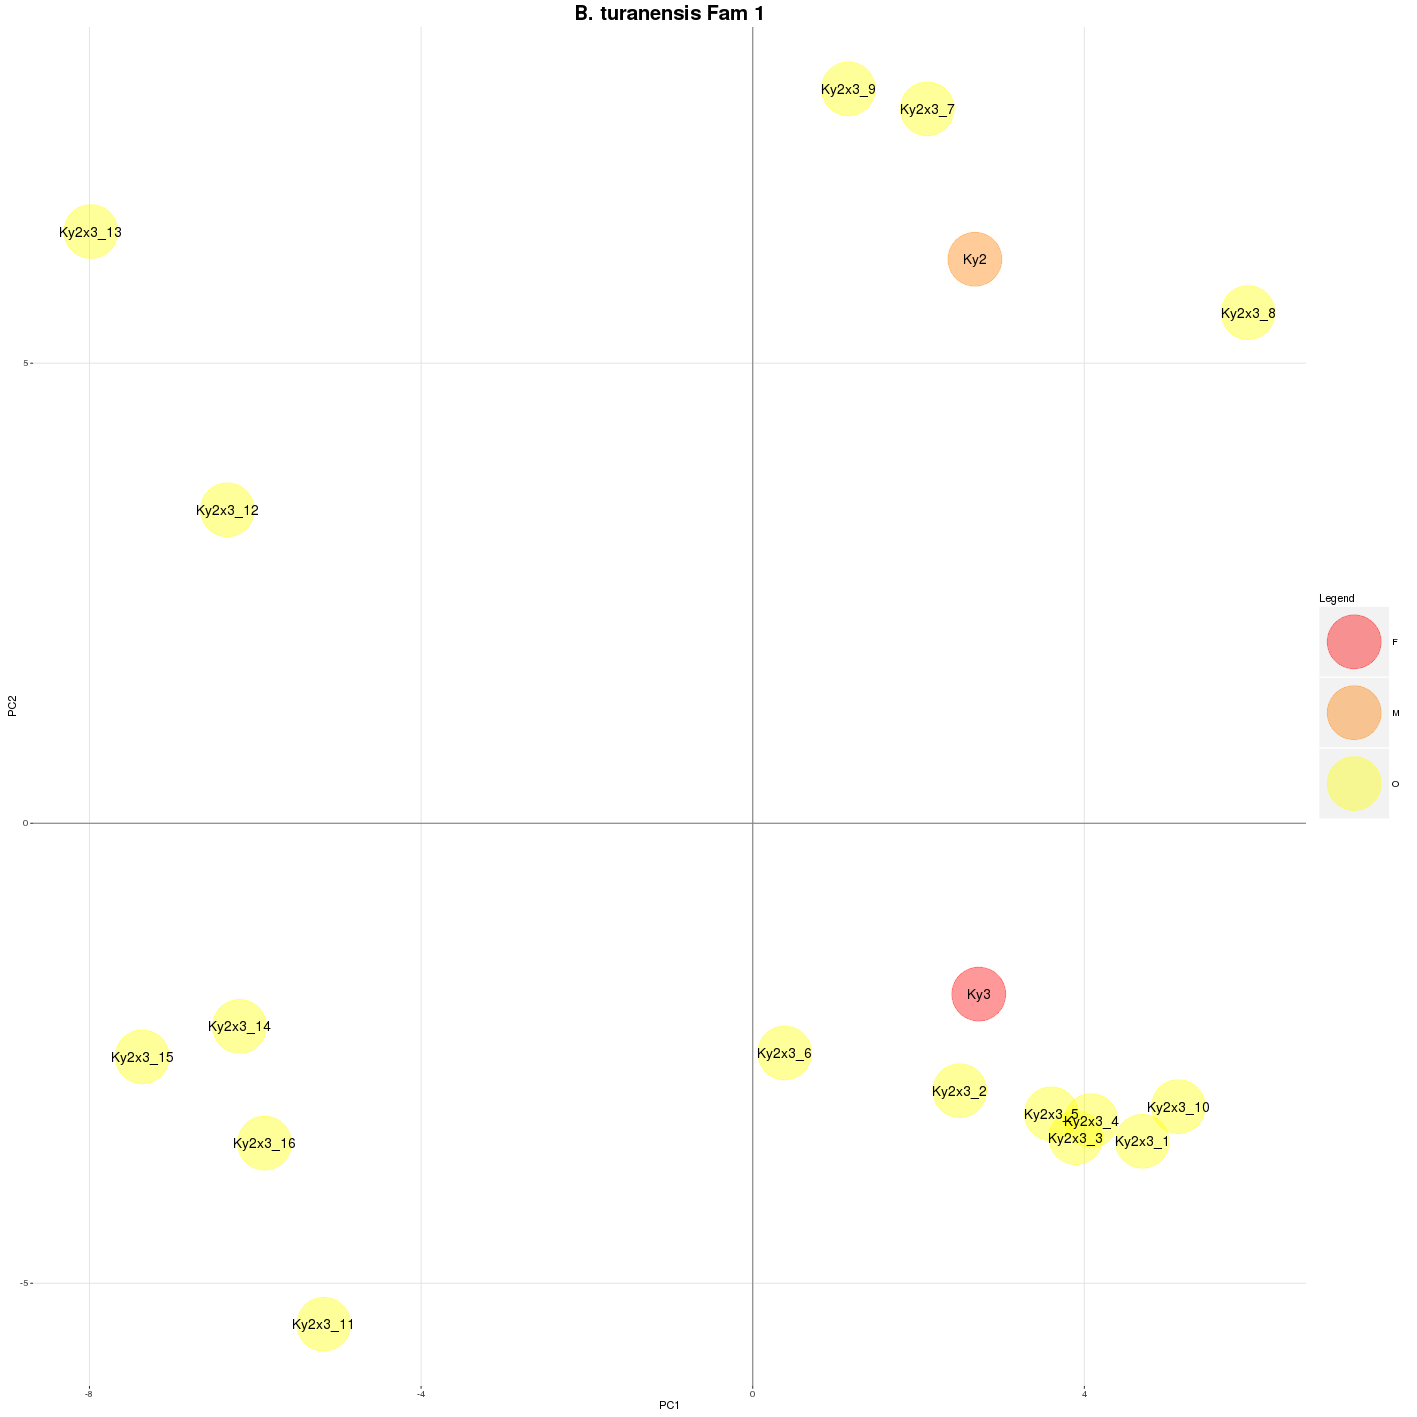

In [74]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. turanensis Fam 1", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So there might be some male female signal there. . . but it isn't that convincing.

So now I will filter the vcf for loci that are heterozygous in the female and homozygous in the male. And see how the offspring fall out at these loci . . . If there are sex linked loci in there I would expect the signal to be stronger after this filtering. I will do this for ZW and XY systems . . . 

### ZW

In [123]:
import vcf

Male = "Ky2"
Female = "Ky3"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/batch_1_altered_adegenet.vcf"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Female: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Male: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        print record
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



Record(CHROM=un, POS=12577, REF=A, ALT=[G])
Record(CHROM=un, POS=21973, REF=C, ALT=[A])
Record(CHROM=un, POS=84371, REF=T, ALT=[C])
Record(CHROM=un, POS=147669, REF=A, ALT=[G])
Record(CHROM=un, POS=160017, REF=T, ALT=[A])
Record(CHROM=un, POS=222332, REF=T, ALT=[C])
Record(CHROM=un, POS=223052, REF=G, ALT=[A])
Record(CHROM=un, POS=223075, REF=A, ALT=[C])
Record(CHROM=un, POS=244794, REF=G, ALT=[T])
Record(CHROM=un, POS=319810, REF=T, ALT=[C])
Record(CHROM=un, POS=319816, REF=C, ALT=[T])
Record(CHROM=un, POS=347937, REF=T, ALT=[C])
Record(CHROM=un, POS=410085, REF=A, ALT=[G])
Record(CHROM=un, POS=413747, REF=A, ALT=[C])
Record(CHROM=un, POS=459104, REF=G, ALT=[A])
Record(CHROM=un, POS=460376, REF=A, ALT=[G])
Record(CHROM=un, POS=478354, REF=C, ALT=[A])
Record(CHROM=un, POS=478376, REF=A, ALT=[G])
Record(CHROM=un, POS=500060, REF=T, ALT=[C])
Record(CHROM=un, POS=571237, REF=T, ALT=[C])
Record(CHROM=un, POS=576429, REF=T, ALT=[C])
Record(CHROM=un, POS=576504, REF=G, ALT=[A])
Record(CHROM=

Now filter the VCF for these loci only and re-run the PCA

In [124]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_altered_adegenet_filtered_loci_ZW.vcf")

In [125]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/  ## just change this line

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet_filtered_loci_ZW.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_filtered_plink_ZW


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_ZW.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_ZW
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_loci_ZW.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_ZW-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_ZW-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_ZW-temporary.f

In [126]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_filtered_plink_ZW.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



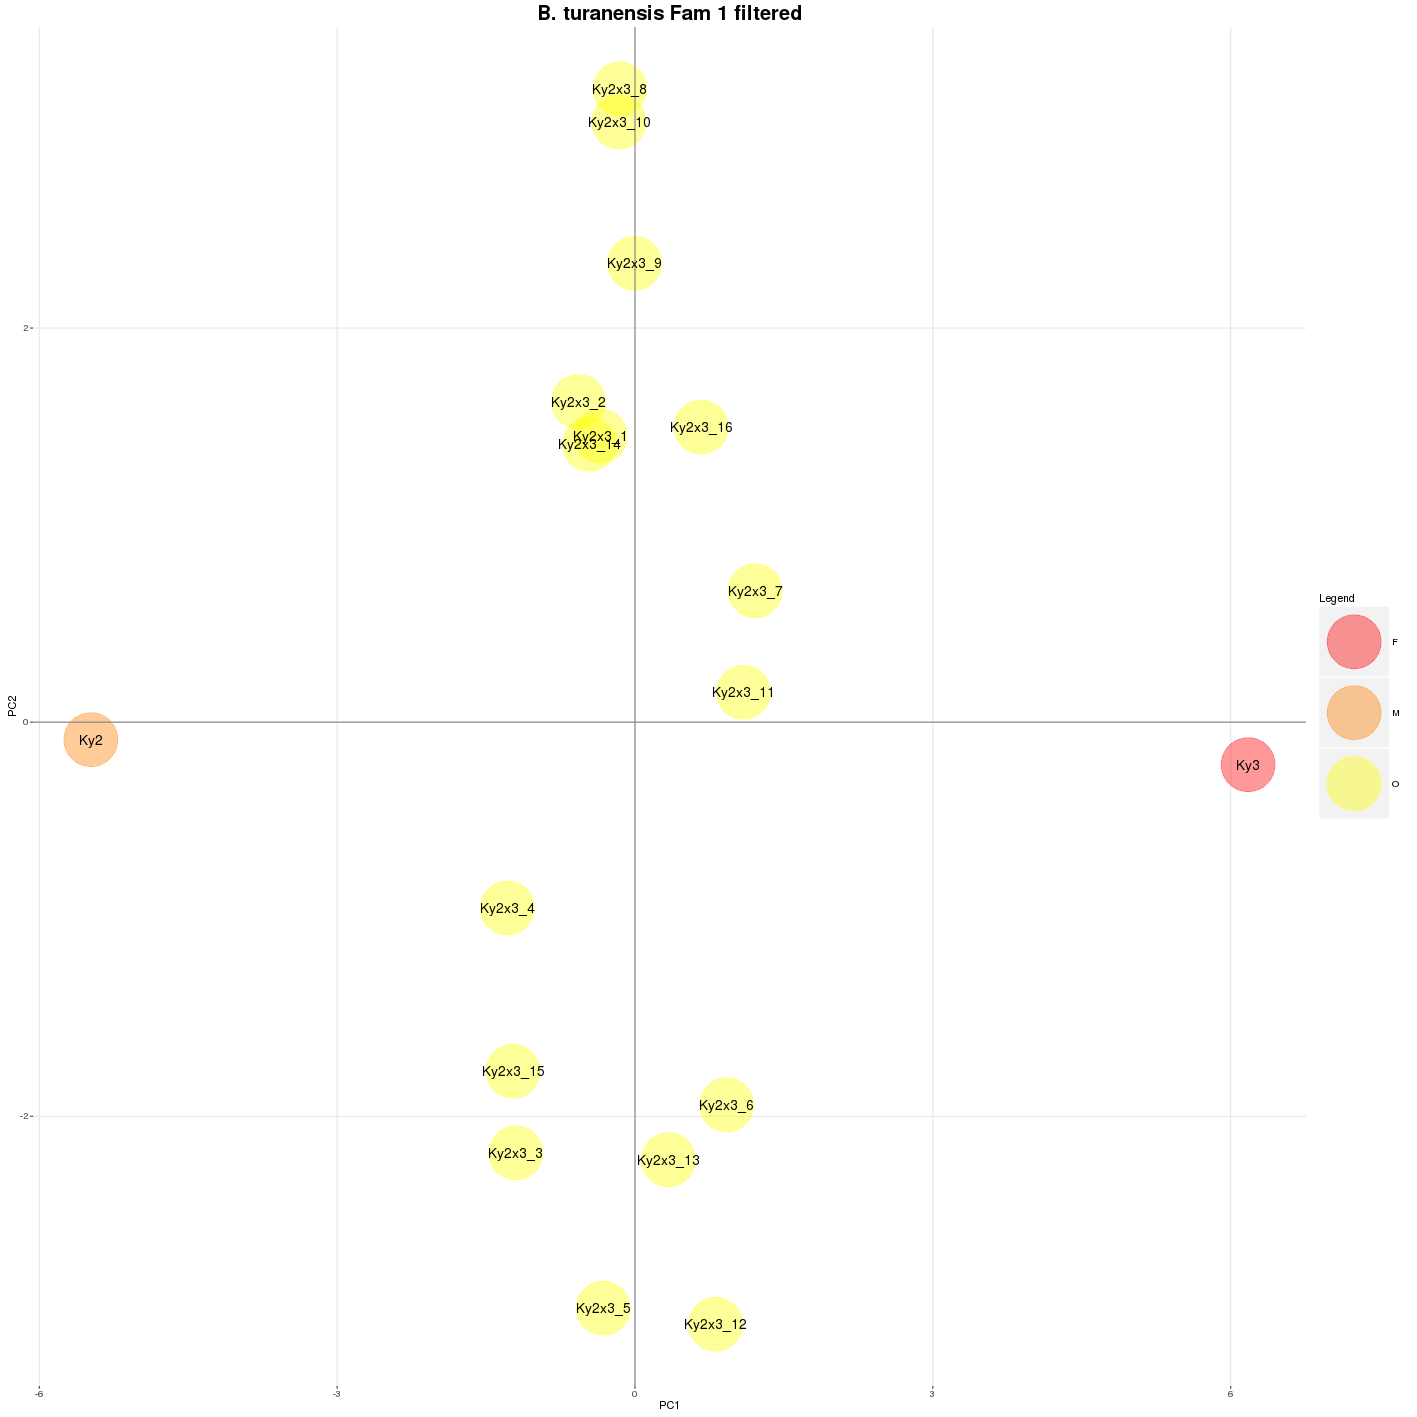

In [127]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. turanensis Fam 1 filtered", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [128]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet_filtered_plink_ZW.raw  $wd/batch_1_filtered_heatmap_input_ZW


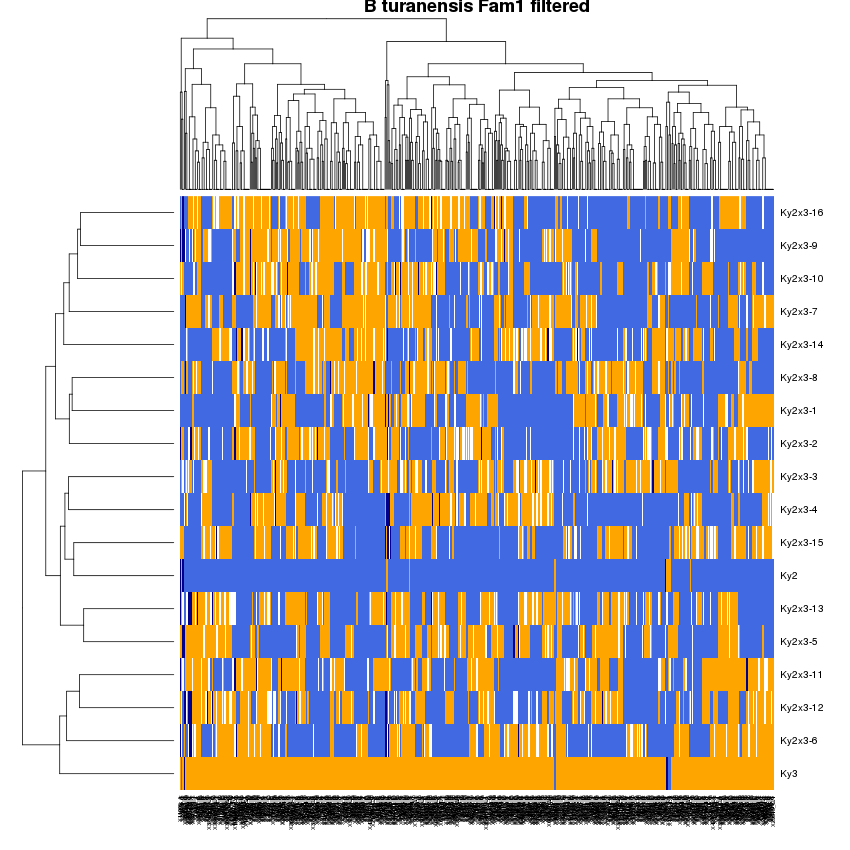

In [129]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/batch_1_filtered_heatmap_input_ZW.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B turanensis Fam1 filtered")

So there is no sign of a sex linked signal here at all. . . . now try for XY system.

### XY

In [130]:
import vcf

Male = "Ky2"
Female = "Ky3"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/batch_1_altered_adegenet.vcf"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Male: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Female: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        print record
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



Record(CHROM=un, POS=3209, REF=T, ALT=[G])
Record(CHROM=un, POS=12583, REF=C, ALT=[T])
Record(CHROM=un, POS=80614, REF=A, ALT=[T])
Record(CHROM=un, POS=84250, REF=G, ALT=[A])
Record(CHROM=un, POS=129256, REF=C, ALT=[T])
Record(CHROM=un, POS=136105, REF=C, ALT=[A])
Record(CHROM=un, POS=137298, REF=A, ALT=[G])
Record(CHROM=un, POS=137300, REF=G, ALT=[A])
Record(CHROM=un, POS=151338, REF=C, ALT=[T])
Record(CHROM=un, POS=189456, REF=A, ALT=[G])
Record(CHROM=un, POS=222381, REF=A, ALT=[C])
Record(CHROM=un, POS=230483, REF=T, ALT=[A])
Record(CHROM=un, POS=230496, REF=G, ALT=[T])
Record(CHROM=un, POS=266304, REF=C, ALT=[T])
Record(CHROM=un, POS=269687, REF=C, ALT=[G])
Record(CHROM=un, POS=269698, REF=A, ALT=[C])
Record(CHROM=un, POS=272152, REF=G, ALT=[C])
Record(CHROM=un, POS=272175, REF=C, ALT=[G])
Record(CHROM=un, POS=282558, REF=A, ALT=[C])
Record(CHROM=un, POS=282583, REF=G, ALT=[A])
Record(CHROM=un, POS=299773, REF=G, ALT=[A])
Record(CHROM=un, POS=313801, REF=G, ALT=[A])
Record(CHROM=un

In [131]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_altered_adegenet_filtered_loci_XY.vcf")

In [132]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/  ## just change this line

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet_filtered_loci_XY.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_filtered_plink_XY


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_XY.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_XY
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_loci_XY.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_XY-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_XY-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1//batch_1_altered_adegenet_filtered_plink_XY-temporary.f

In [133]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1") 

## All SNPs (about 80,000)
alldataXY <- read.PLINK('batch_1_altered_adegenet_filtered_plink_XY.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca2 <- glPca(alldataXY, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



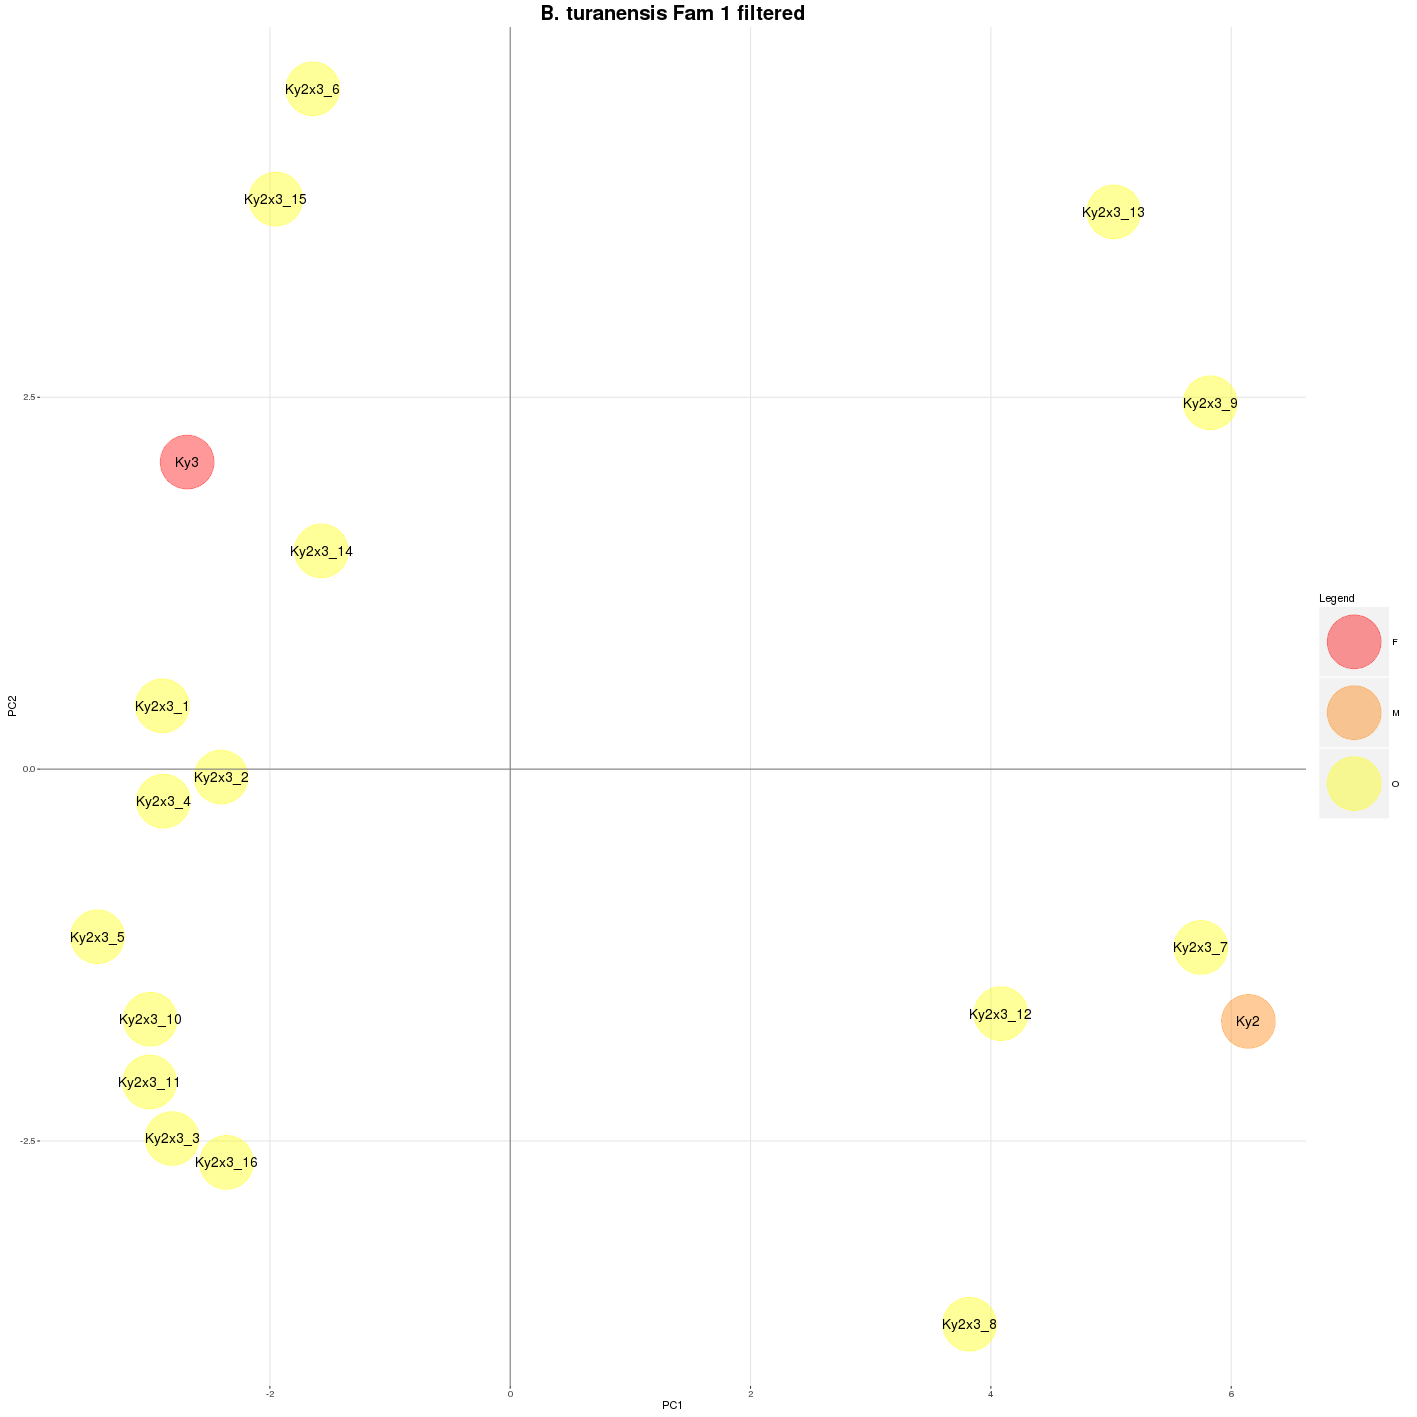

In [134]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap.txt", header = F)

Sex_sorter(pca2,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. turanensis Fam 1 filtered", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [135]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet_filtered_plink_XY.raw  $wd/batch_1_filtered_heatmap_input_XY


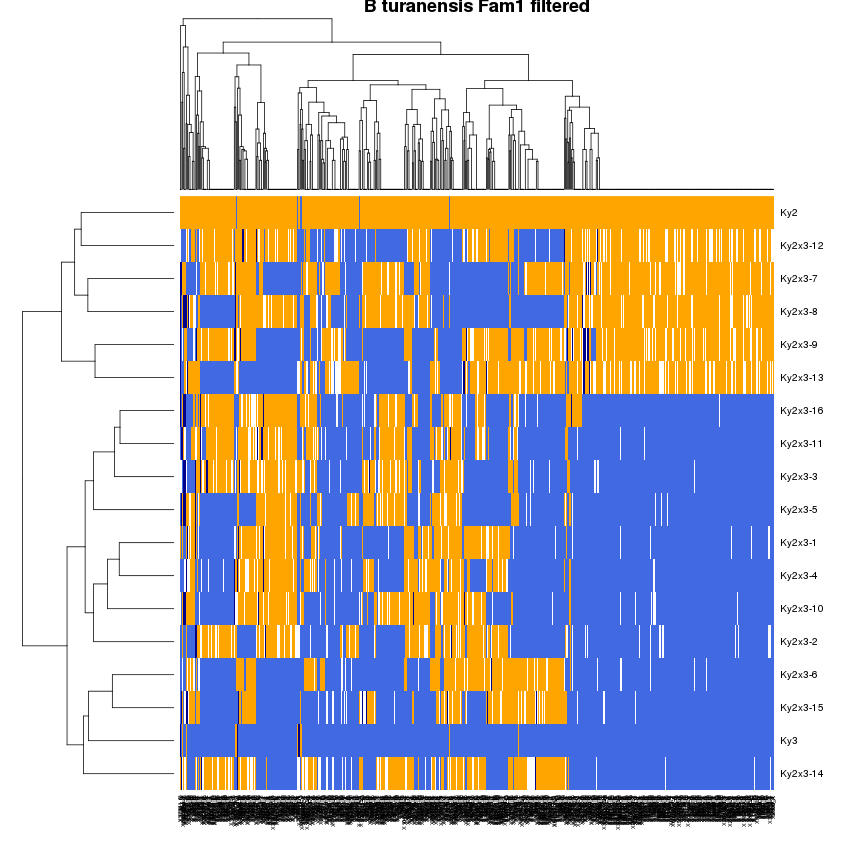

In [136]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Populations_Turnanensis_fam1/batch_1_filtered_heatmap_input_XY.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B turanensis Fam1 filtered")

Ok, so here there is some good signal for sex linked markers. . . . in approximately a third (on the right) of all of the loci that are heterozygous in the father and homozygous in the mother of the family, the offspring also show consistent sex-linked signal between them.

So now I can apply sex assignments to these offspring and see how they do in the traditional sex linked marker tests using sexed family data.

In [175]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam1/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam1/sex_info.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.6
hom = 1

In [176]:
Fam1_XY, Fam1_ZW = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom )

Number of good loci = 1059

N loci suitable for XY testing: 557
N XY test loci with enough heterozygous males: 323
N loci that fit the specified XY criteria: 140

N loci suitable for ZW testing: 502
N ZW test loci with enough heterozygous females: 491
N loci that fit the specified ZW criteria: 0


### Ok so thats pretty conclusive - as long as the male and female are the right way around in the samples, then this is an XY system. . . 

Now do the same for family 2

## Fam 2.

### ZW

In [146]:
import vcf

Male = "Ky16_2"
Female = "Ky15"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/batch_1.vcf"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Female: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Male: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



1320 517


In [149]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_filtered_loci_ZW.vcf")

In [154]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/  ## just change this line

sed 's/_/-/g' $wd/batch_1_filtered_loci_ZW.vcf > $wd/batch_1_filtered_altered_adegenet_ZW.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_filtered_altered_adegenet_ZW.vcf --recode A --allow-extra-chr -out $wd/batch_1_filtered_altered_adegenet_ZW_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_ZW_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_ZW_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_ZW.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_ZW_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_ZW_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_tura

In [152]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/") 

## All SNPs (about 80,000)
alldataFam2ZW <- read.PLINK('batch_1_filtered_altered_adegenet_ZW_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca3 <- glPca(alldataFam2ZW, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



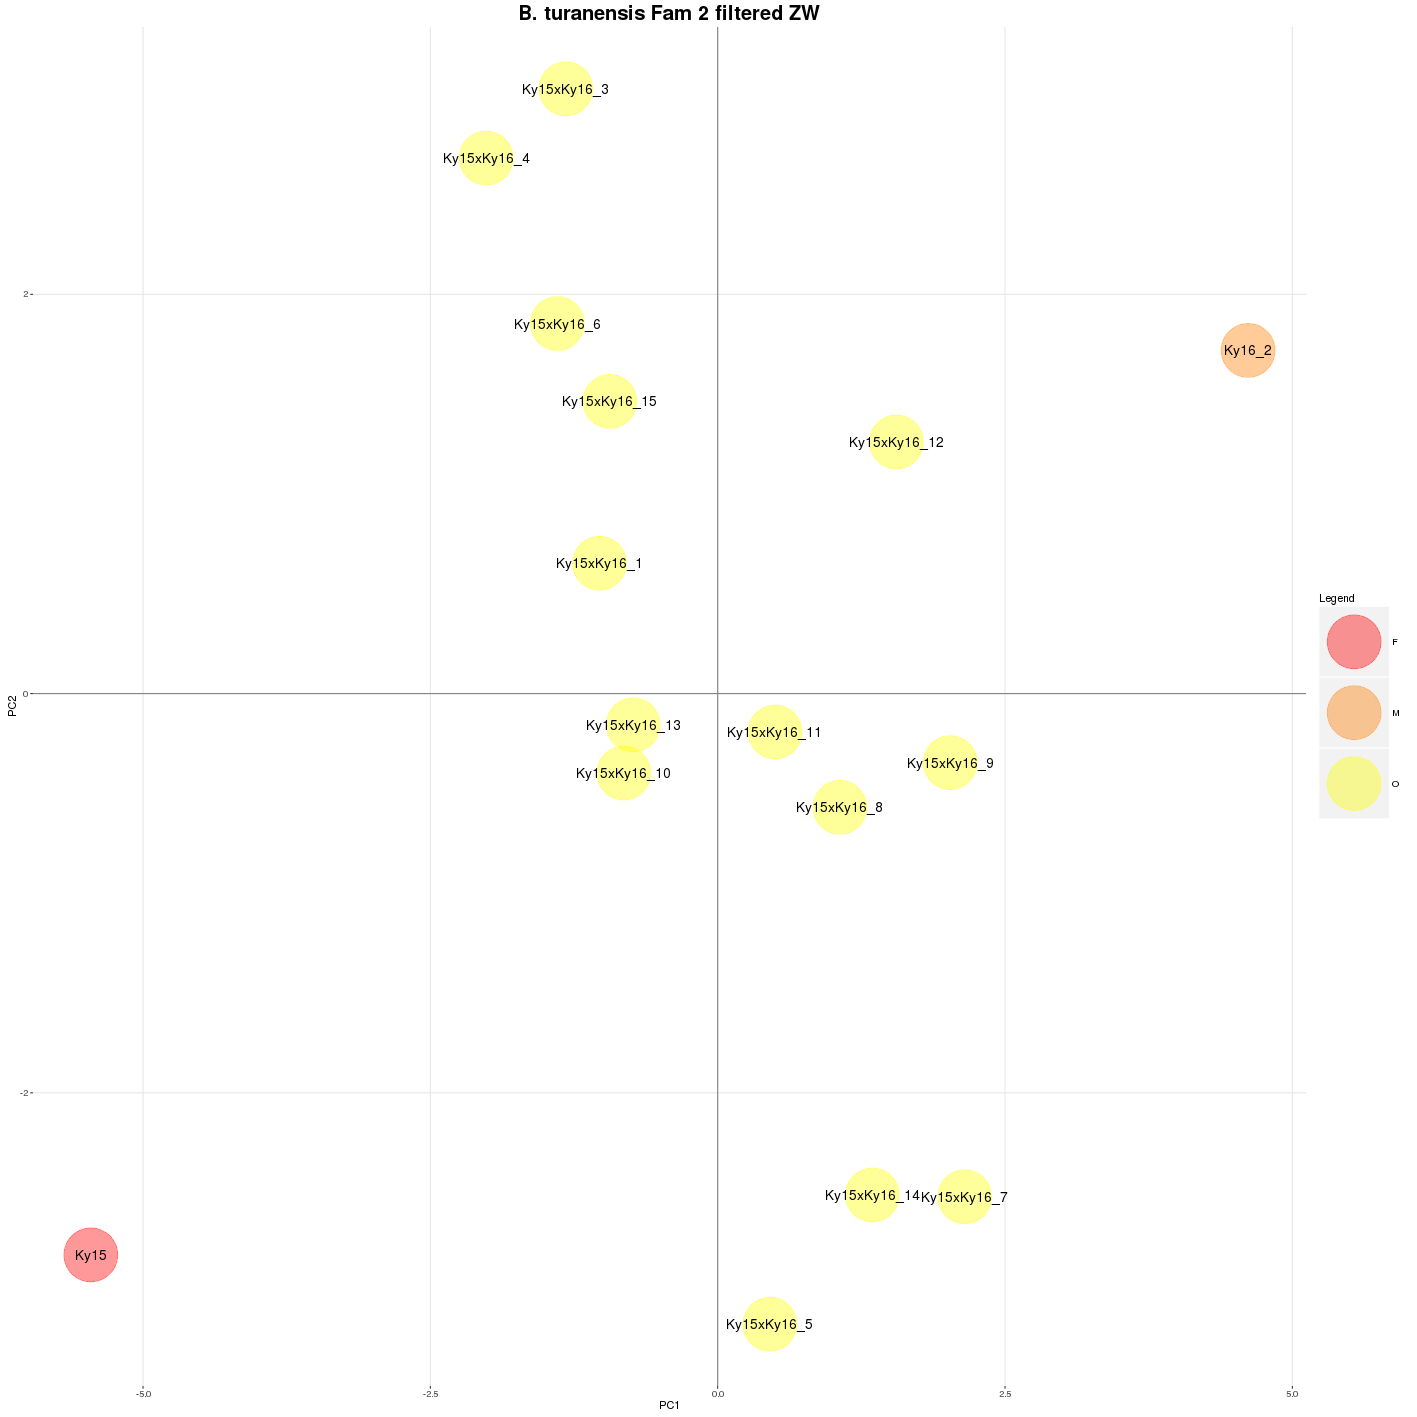

In [153]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap.txt", header = F)

Sex_sorter(pca3,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. turanensis Fam 2 filtered ZW", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [155]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_filtered_altered_adegenet_ZW_plink.raw  $wd/batch_1_filtered_heatmap_input_ZW


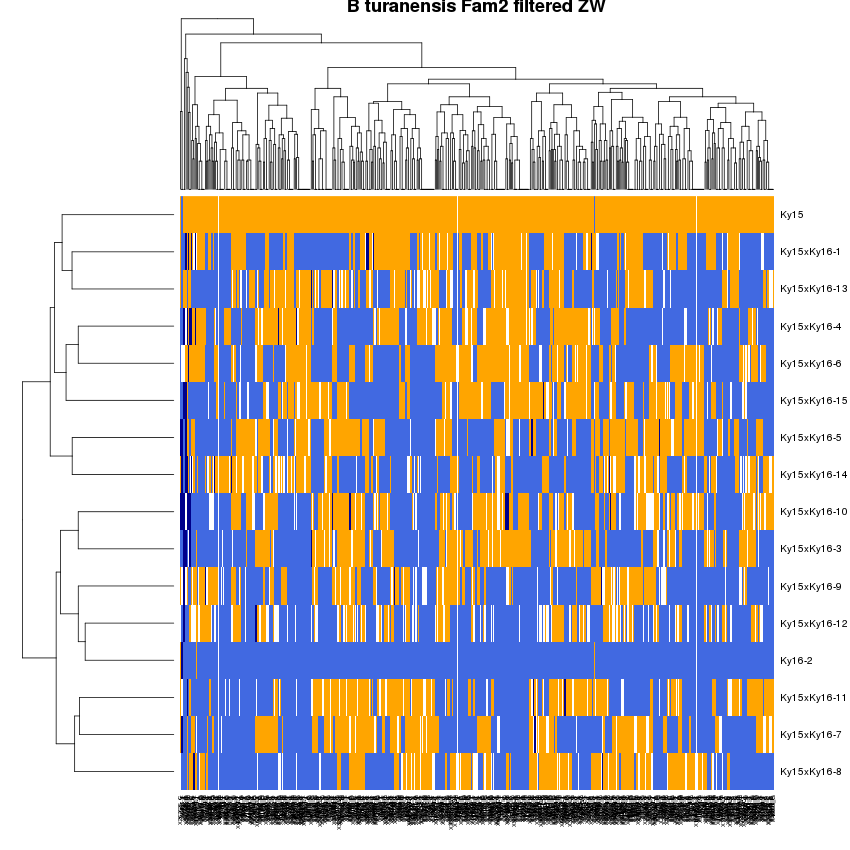

In [156]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/batch_1_filtered_heatmap_input_ZW.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B turanensis Fam2 filtered ZW")

ok so nothing again for the ZW, but now try XY again. . . 

## XY

In [157]:
import vcf

Male = "Ky16_2"
Female = "Ky15"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/batch_1.vcf"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Male: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Female: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



1320 460


In [158]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_filtered_loci_XY.vcf")

In [159]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/  ## just change this line

sed 's/_/-/g' $wd/batch_1_filtered_loci_XY.vcf > $wd/batch_1_filtered_altered_adegenet_XY.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_filtered_altered_adegenet_XY.vcf --recode A --allow-extra-chr -out $wd/batch_1_filtered_altered_adegenet_XY_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_XY_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_XY_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_XY.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_XY_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2//batch_1_filtered_altered_adegenet_XY_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_tura

In [160]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/") 

## All SNPs (about 80,000)
alldataFam2XY <- read.PLINK('batch_1_filtered_altered_adegenet_XY_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca4 <- glPca(alldataFam2XY, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



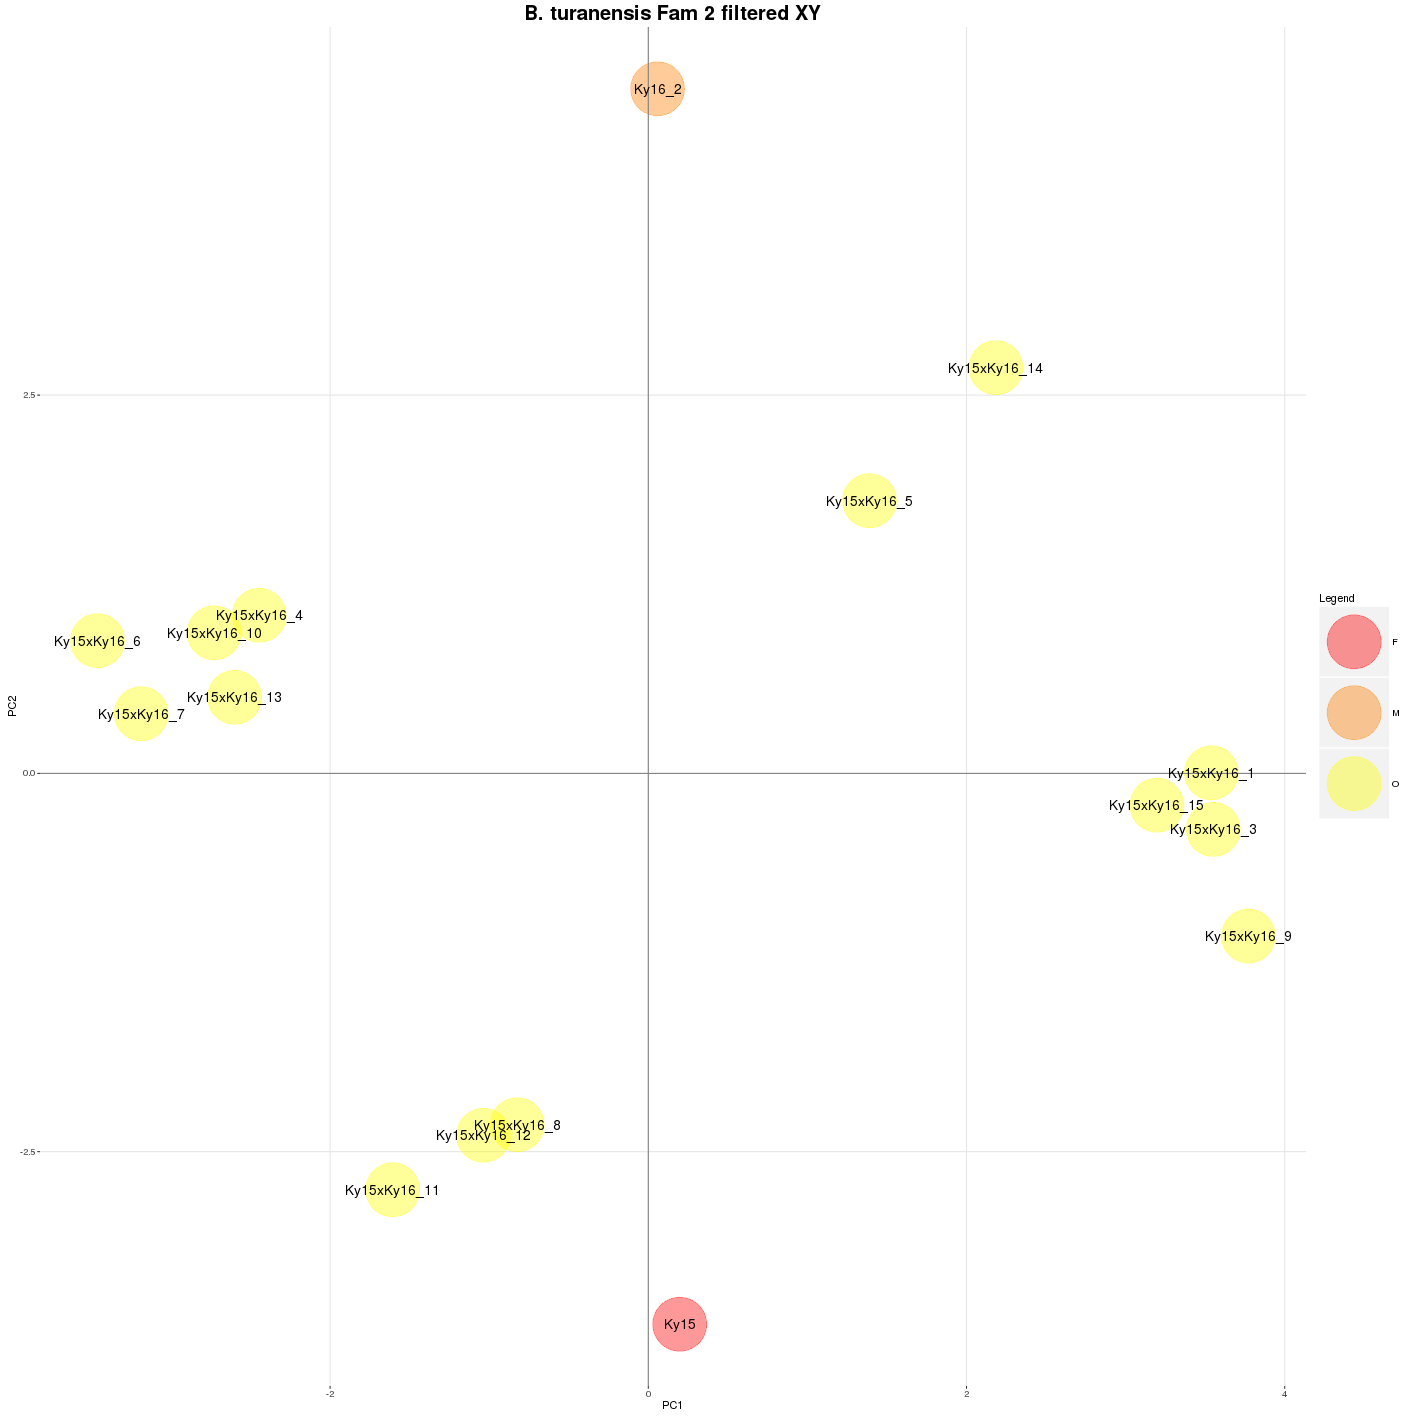

In [161]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap.txt", header = F)

Sex_sorter(pca4,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. turanensis Fam 2 filtered XY", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [162]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_filtered_altered_adegenet_XY_plink.raw  $wd/batch_1_filtered_heatmap_input_XY


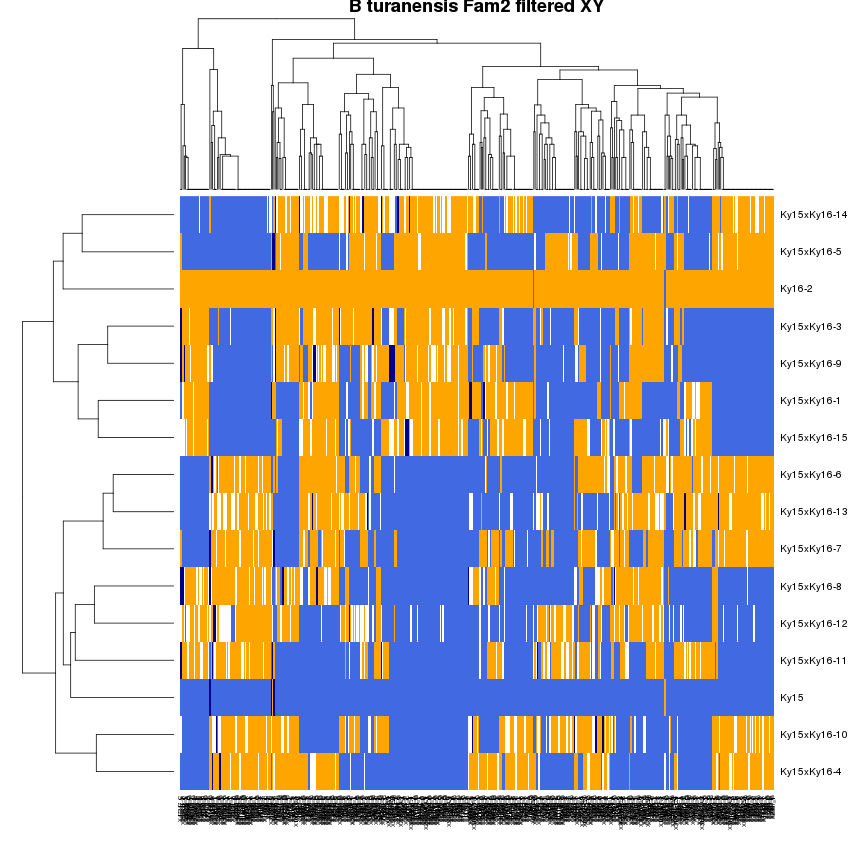

In [163]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/batch_1_filtered_heatmap_input_XY.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B turanensis Fam2 filtered XY")

ok. . . So things aren't quite as clear here, but I think there is still a good separation within the offspring. I think the trouble is perhaps caused by a set of markers that look X specific. So I will try the SLM search with these assignments and see what it looks like. 

In [184]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_turanensis/Populations_Turnanensis_fam2/sex_info.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.6
hom = 1

In [185]:
Fam2_XY, Fam2_ZW = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom )

Number of good loci = 850

N loci suitable for XY testing: 398
N XY test loci with enough heterozygous males: 120
N loci that fit the specified XY criteria: 44

N loci suitable for ZW testing: 452
N ZW test loci with enough heterozygous females: 419
N loci that fit the specified ZW criteria: 0


<matplotlib_venn._common.VennDiagram instance at 0x7f43009a6b48>

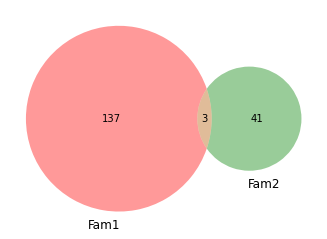

In [177]:
from matplotlib_venn import venn2

venn2((set(Fam1_XY), set(Fam2_XY)), ("Fam1", "Fam2"))



### Ok, so there are some sex linked markers here. I am quite confident about this sexing approach, however I am not sure how it will stand up to a reviewer . . . 

Also, in the second family, there seem to be quite a lot of X-specific markers . . . These should also be on the sex chromosome. I can get these using the normal SLM finding technique and perhaps increase the number of loci found in total. . . . importantly I would need to check for overlap across the dataset, to test that there is some signal here. 

### So come back to find the X-spcific markers at a later date if needed

## Bufo shaartusiensis

1 family with Mother, Father and about 32 unsexed offspring t- should be quite good if I can sex them in the same was as I did with turanensis.

In [187]:
import vcf

Male = "Sz22"
Female = "Sz23"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1.vcf"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Female: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Male: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": 
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



2190 806


In [190]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_filtered_loci_ZW.vcf")

In [191]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis  ## just change this line

sed 's/_/-/g' $wd/batch_1_filtered_loci_ZW.vcf > $wd/batch_1_filtered_altered_adegenet_ZW.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_filtered_altered_adegenet_ZW.vcf --recode A --allow-extra-chr -out $wd/batch_1_filtered_altered_adegenet_ZW_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_ZW_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_ZW_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_ZW.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_ZW_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_ZW_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo

In [193]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/") 

## All SNPs (about 80,000)
alldatashaarZW <- read.PLINK('batch_1_filtered_altered_adegenet_ZW_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca5 <- glPca(alldatashaarZW, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



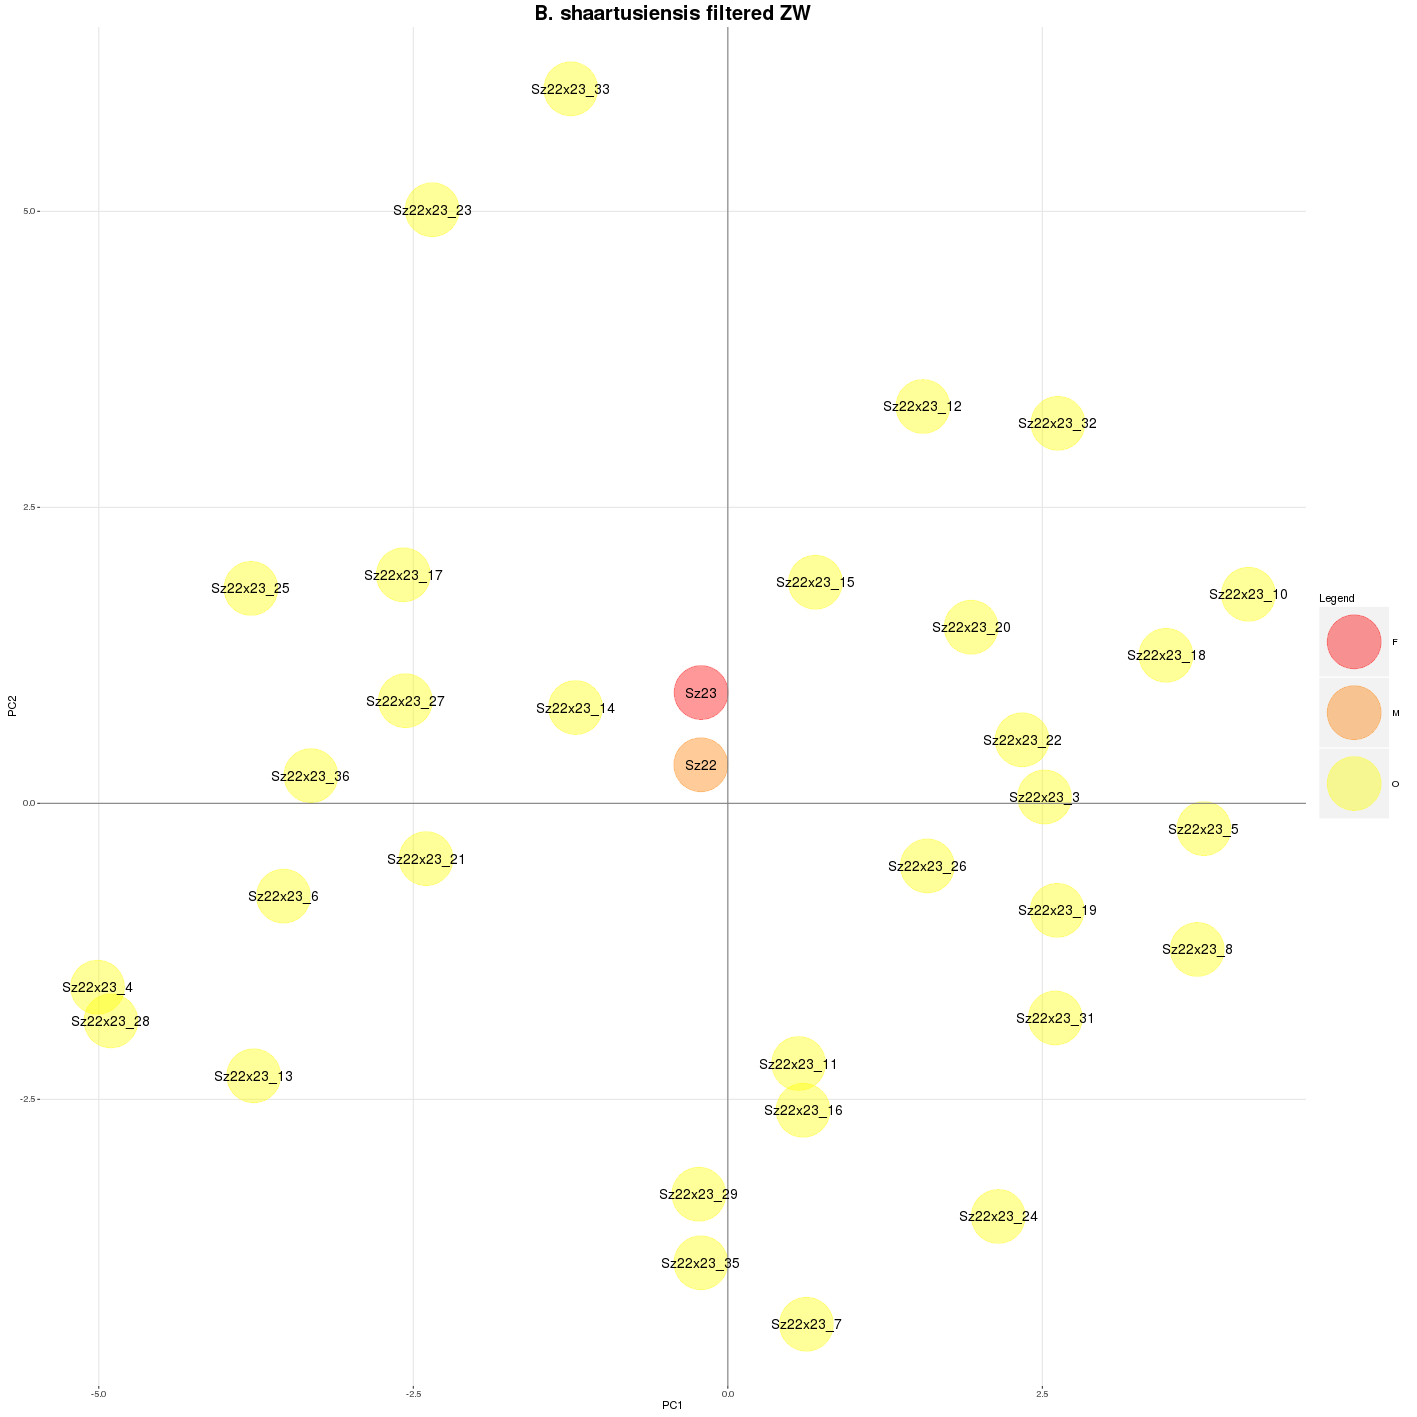

In [208]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popcodes.txt", header = F)

Sex_sorter(pca5,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. shaartusiensis filtered ZW", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [197]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_filtered_altered_adegenet_ZW_plink.raw  $wd/batch_1_filtered_heatmap_input_ZW


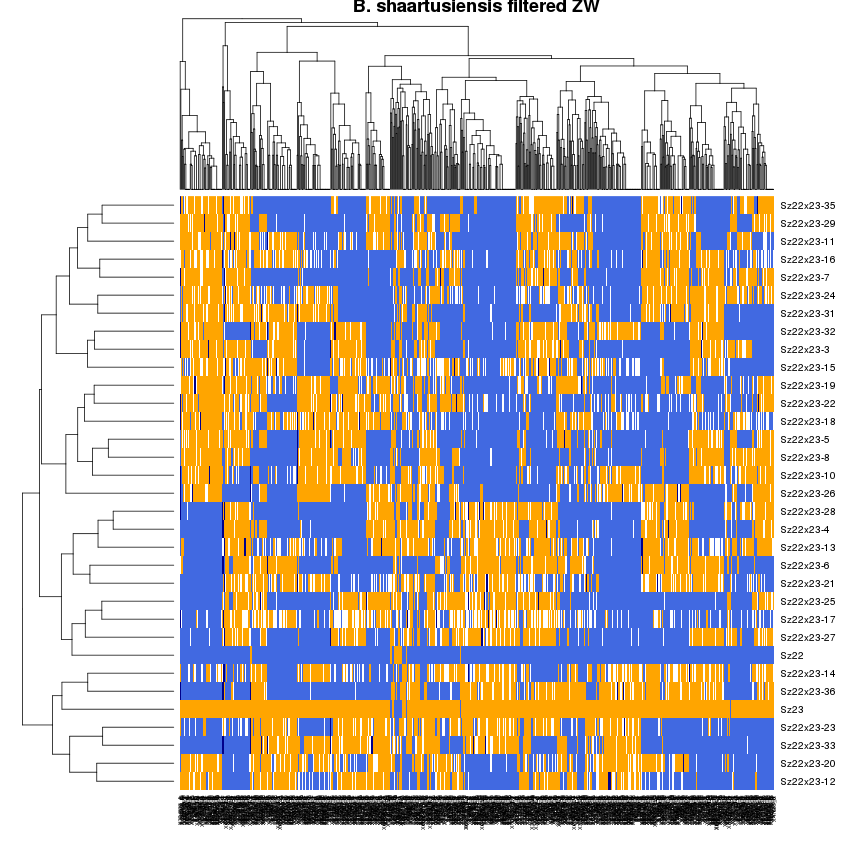

In [198]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis//batch_1_filtered_heatmap_input_ZW.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B. shaartusiensis filtered ZW")

So there is some signal here - maybe there are some ZW markers but not enough that it is the overwhelming signal in the dataset.
### So now try XY

## XY

In [202]:
import vcf

Male = "Sz22"
Female = "Sz23"


vcf_path = "/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1.vcf"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    Fem_het = False
    Male_hom = False

    for sample in record.samples:
        
        if sample.sample == Male: ## for the female genotype at this locus
            if sample.is_het: ## If the female is heterozygous
                Fem_het = True

    if Fem_het == True:
        for sample in record.samples:

            if sample.sample == Female: ## for the female genotype at this locus
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": ## If the female is heterozygous
                    Male_hom = True

    if all([Fem_het == True, Male_hom == True]):
        
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



2190 859


In [203]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_filtered_loci_XY.vcf")

In [204]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis  ## just change this line

sed 's/_/-/g' $wd/batch_1_filtered_loci_XY.vcf > $wd/batch_1_filtered_altered_adegenet_XY.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_filtered_altered_adegenet_XY.vcf --recode A --allow-extra-chr -out $wd/batch_1_filtered_altered_adegenet_XY_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_XY_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_XY_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_XY.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_XY_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_filtered_altered_adegenet_XY_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo

In [206]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/") 

## All SNPs (about 80,000)
alldatashaarXY <- read.PLINK('batch_1_filtered_altered_adegenet_XY_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca6 <- glPca(alldatashaarXY, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



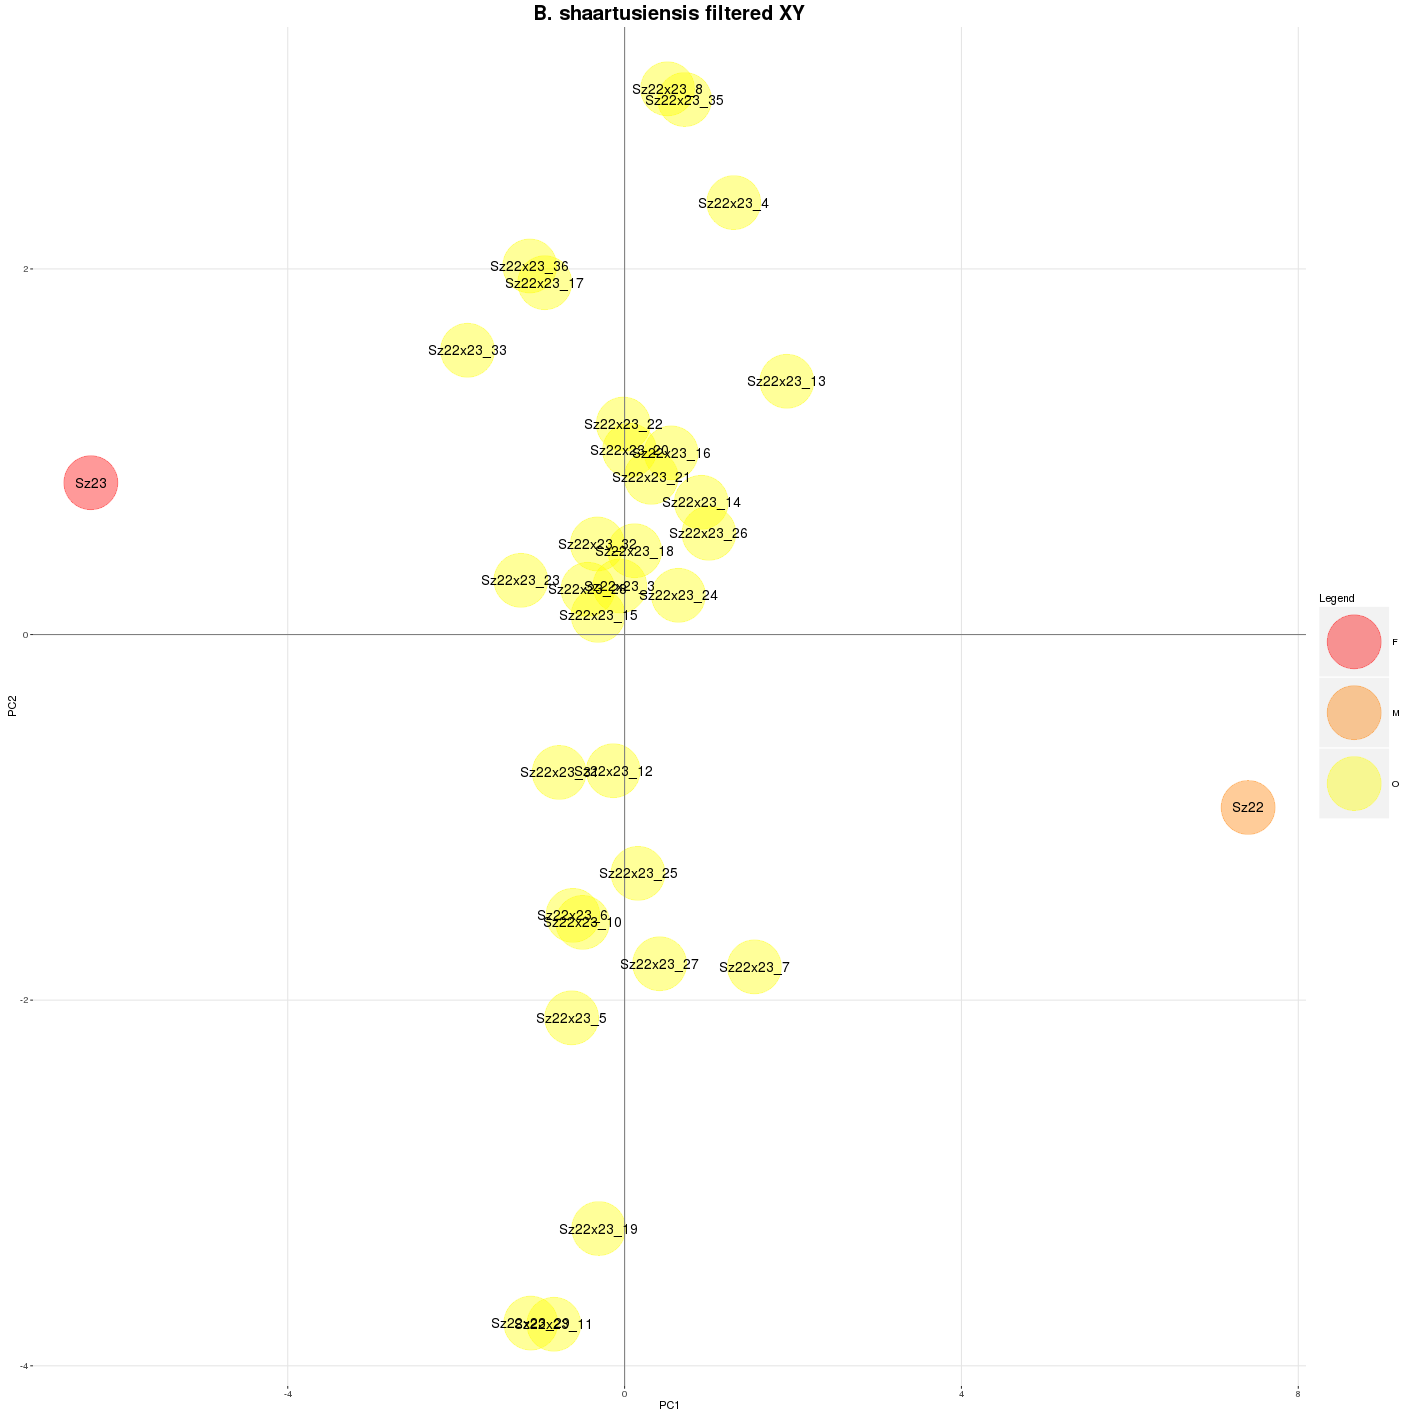

In [210]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popcodes.txt", header = F)

Sex_sorter(pca6,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. shaartusiensis filtered XY", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [212]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_filtered_altered_adegenet_XY_plink.raw  $wd/batch_1_filtered_heatmap_input_XY


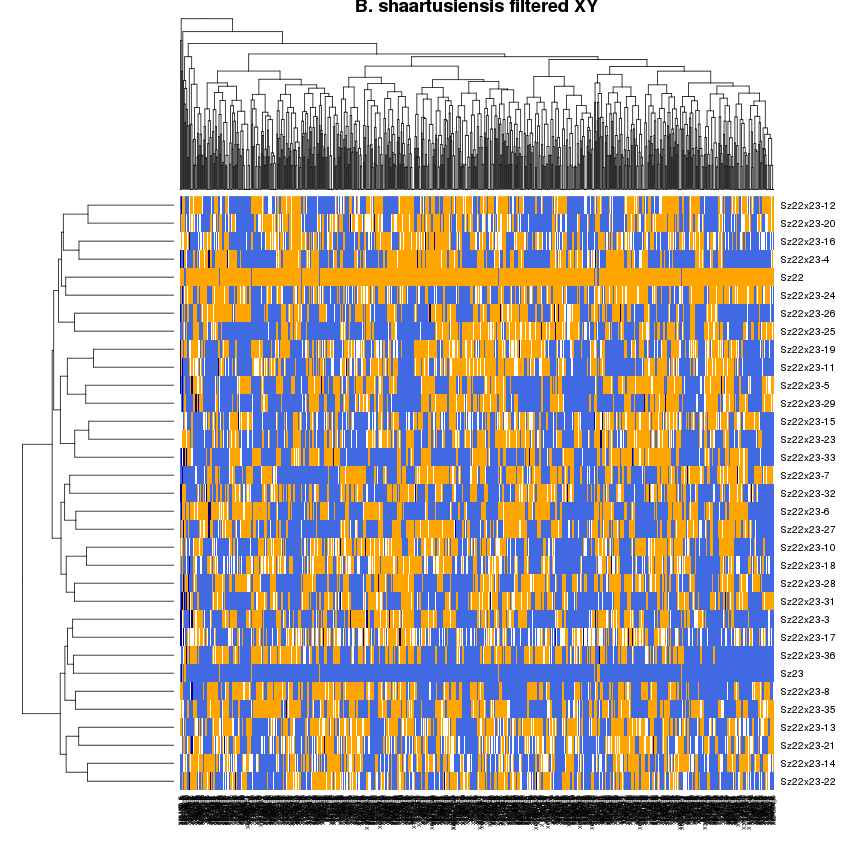

In [213]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis//batch_1_filtered_heatmap_input_XY.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B. shaartusiensis filtered XY")

### No signal at all here. . . . so it looks like this system could be ZW

So I will assign samples based on the heatmap for the ZW system . . . Not exactly how the dendogram has clustered them though, I will follow the homozygous/heterozygous pattern for the loci on the very left of the heatmap

In [269]:
vcf = "/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1.vcf"
sex = "/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/sex_info.txt"
cat = "/home/djeffrie/Data/RADseq/STOECK/batch_1.catalog.tags.tsv.gz"
off = 0.75
mend = 0.75
het = 0.6
hom = 0.9

In [270]:
Shaar_XY, Shaar_ZW = MISC.SL_markers_from_sexed_fam(vcf,sex, cat, off,mend, het, hom )

Number of good loci = 1484

N loci suitable for XY testing: 768
N XY test loci with enough heterozygous males: 55
N loci that fit the specified XY criteria: 0

N loci suitable for ZW testing: 716
N ZW test loci with enough heterozygous females: 650
N loci that fit the specified ZW criteria: 42


So there are some here, but not as many as I expected - lets plot the samples at the loci identified and see what they look like, maybe I mis-assigned some.

In [260]:
Shaar_ZW = [i.split("_")[0] for i in Shaar_ZW]

In [261]:
MISC.filter_vcf_tag_ID_only(vcf_path, Shaar_ZW, "batch_1_ZW_only.vcf")

In [262]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis  ## just change this line

sed 's/_/-/g' $wd/batch_1_ZW_only.vcf > $wd/batch_1_ZW_only_adegenet.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_ZW_only_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_ZW_only_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_ZW_only_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_ZW_only_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_ZW_only_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_ZW_only_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_ZW_only_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/batch_1_ZW_only_plink-temporary.fam
written.
18 varia

In [263]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_shaartusiensis/Populations_shaartusiensis/") 

## All SNPs (about 80,000)
alldatashaarZWonly <- read.PLINK('batch_1_ZW_only_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca7 <- glPca(alldatashaarZWonly, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



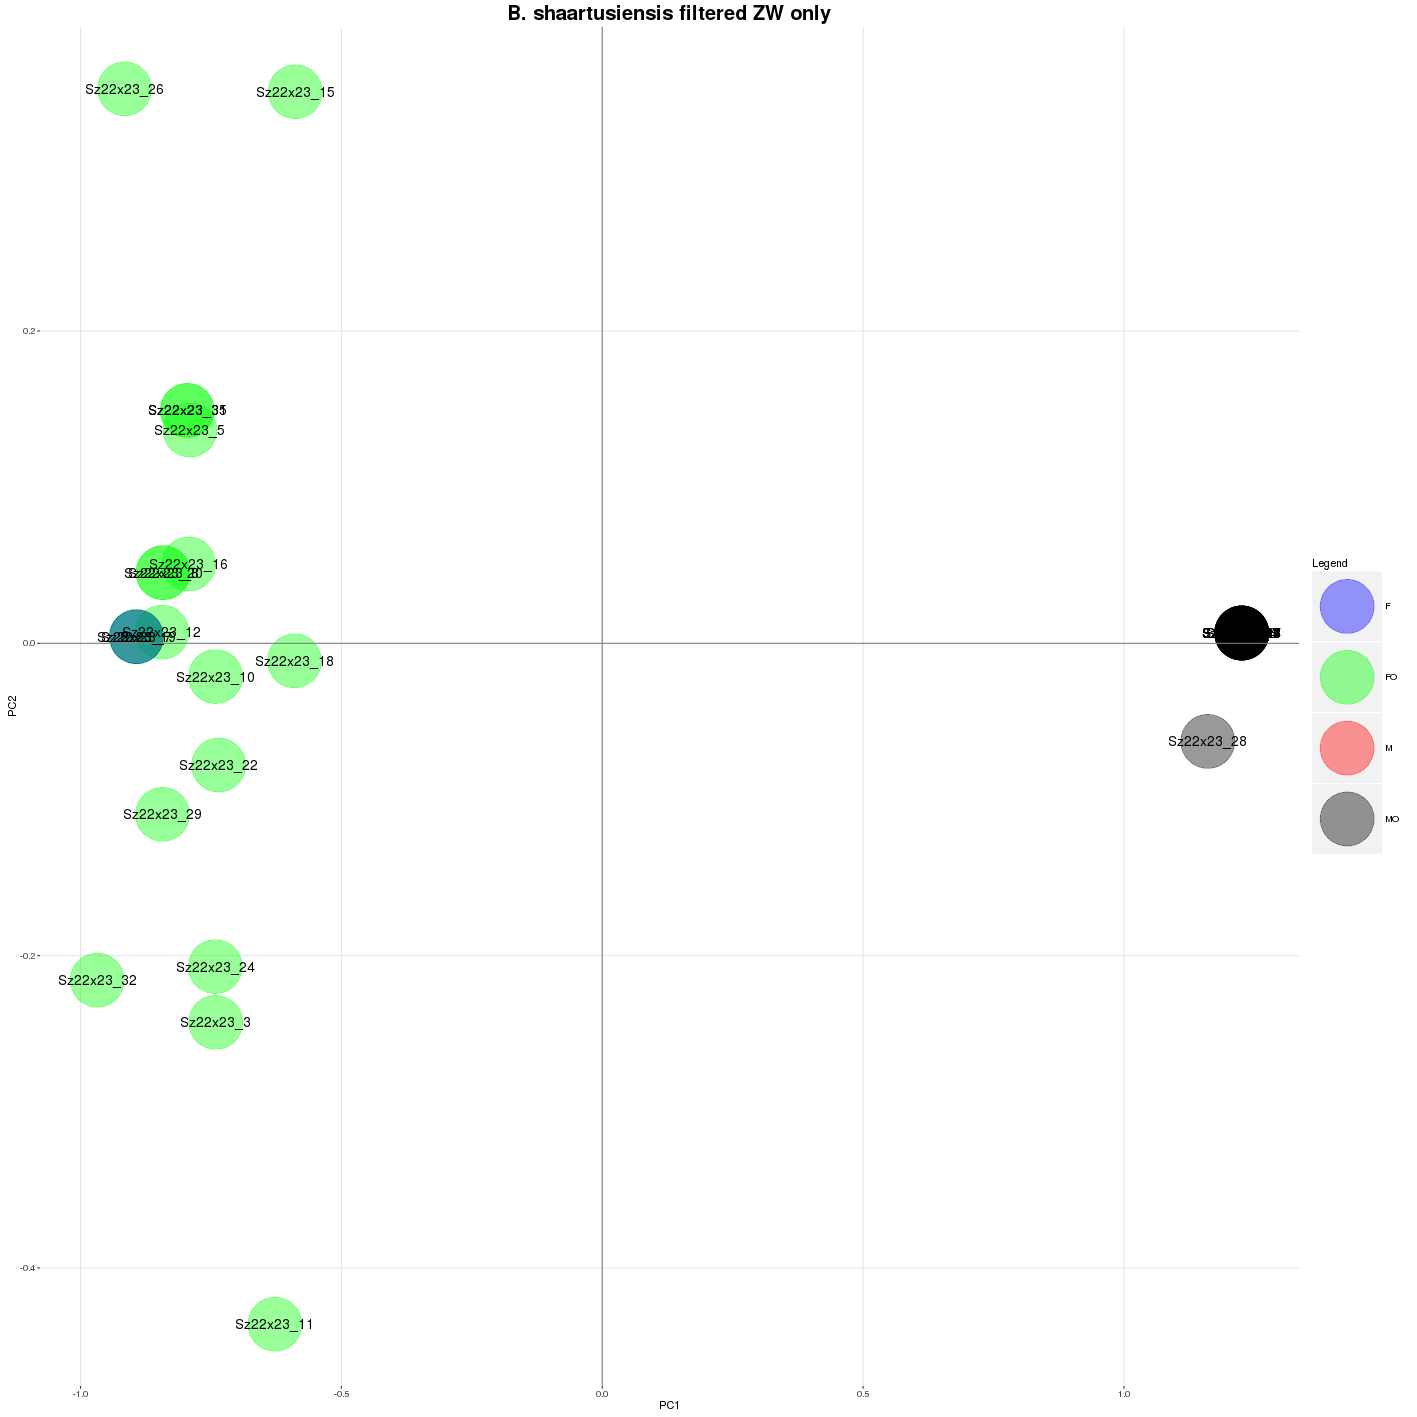

In [264]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("sex_info.txt", header = F)

Sex_sorter(pca7,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. shaartusiensis filtered ZW only", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = c("blue", "green", "red", "black"),            #Palette = rainbow(10), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

##Bufo latastii

One family, no parents, no sexes. . . just offspring. 

In [271]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii  ## just change this line

sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_adegenet.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_plink-temporary.fam
written.
6376 variants loaded from .bim file.
19 people (0 males, 0 females, 19 ambiguous) loaded from .fam.
Ambiguous sex IDs written to

In [272]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii") 

## All SNPs (about 80,000)
Blat <- read.PLINK('batch_1_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca8 <- glPca(Blat, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



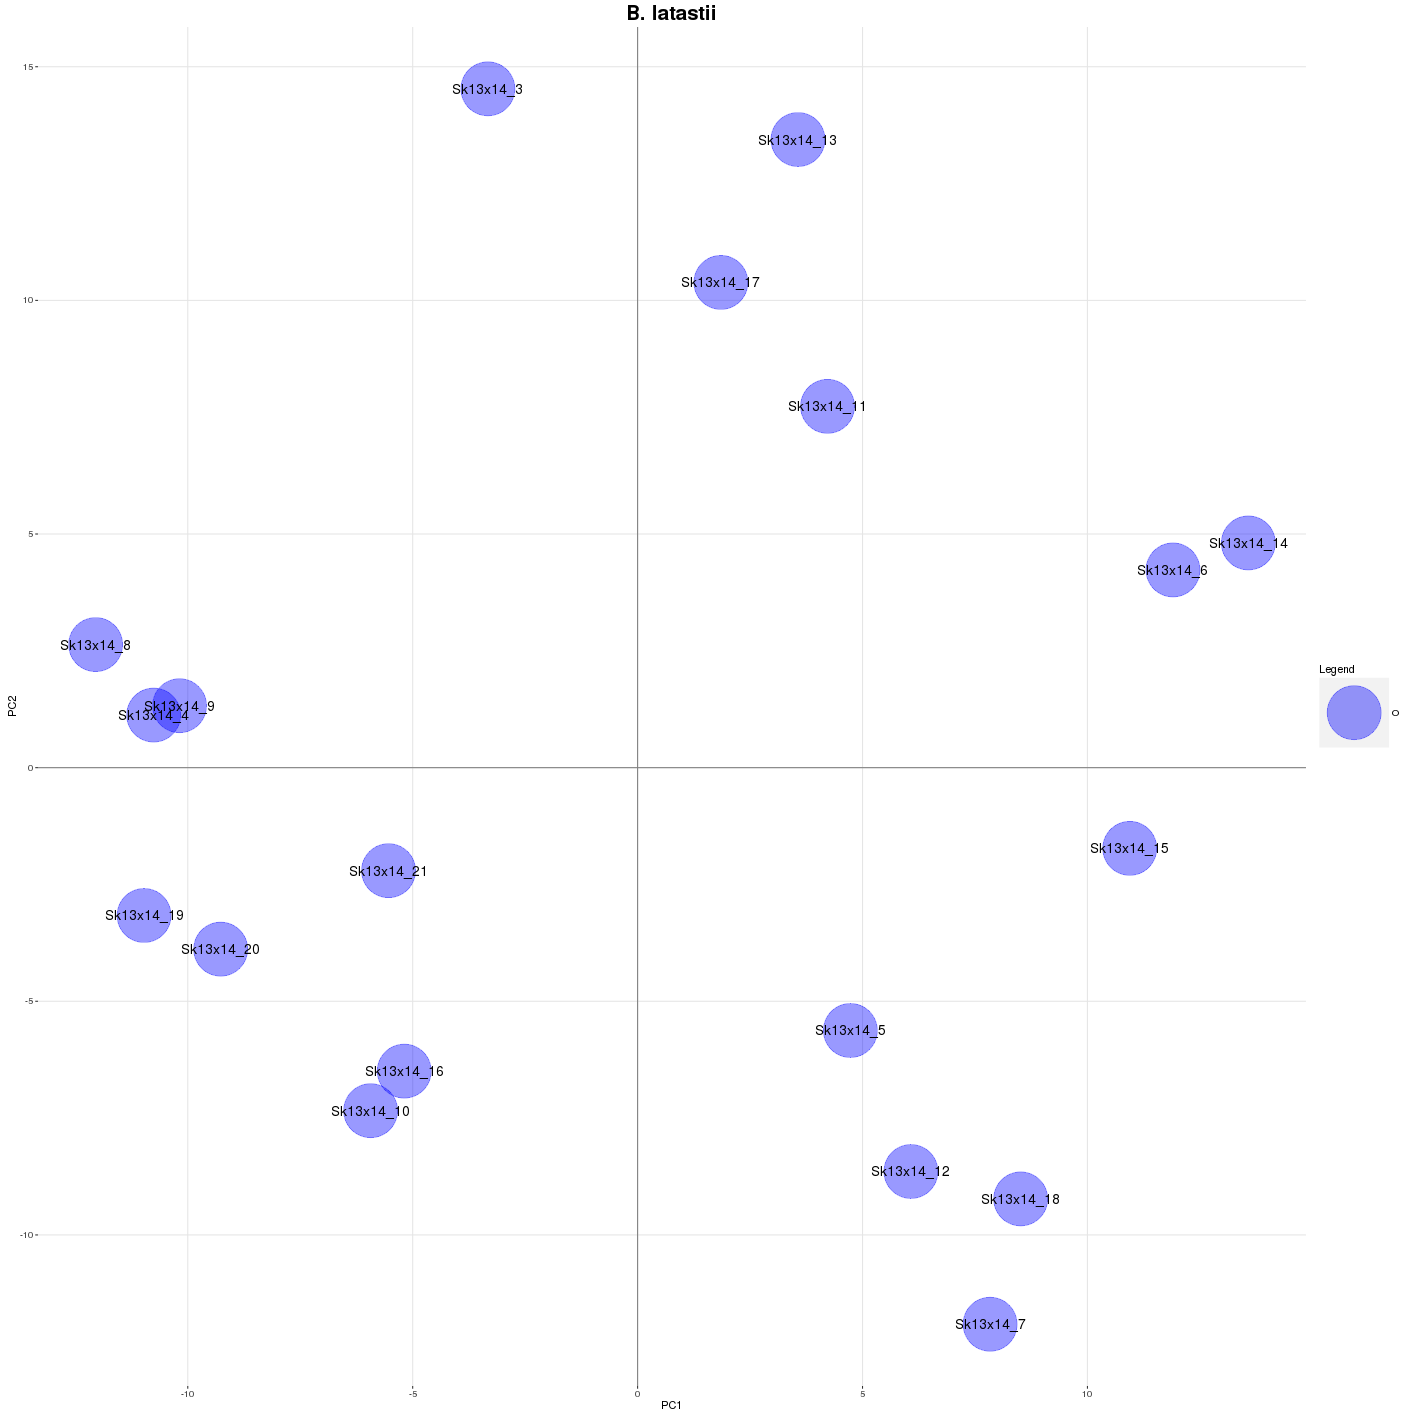

In [273]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popcodes.txt", header = F)

Sex_sorter(pca8,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "B. latastii", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = c("blue", "green", "red", "black"),            #Palette = rainbow(10), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [274]:
%%bash

wd=/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_plink.raw  $wd/batch_1_heatmap_input


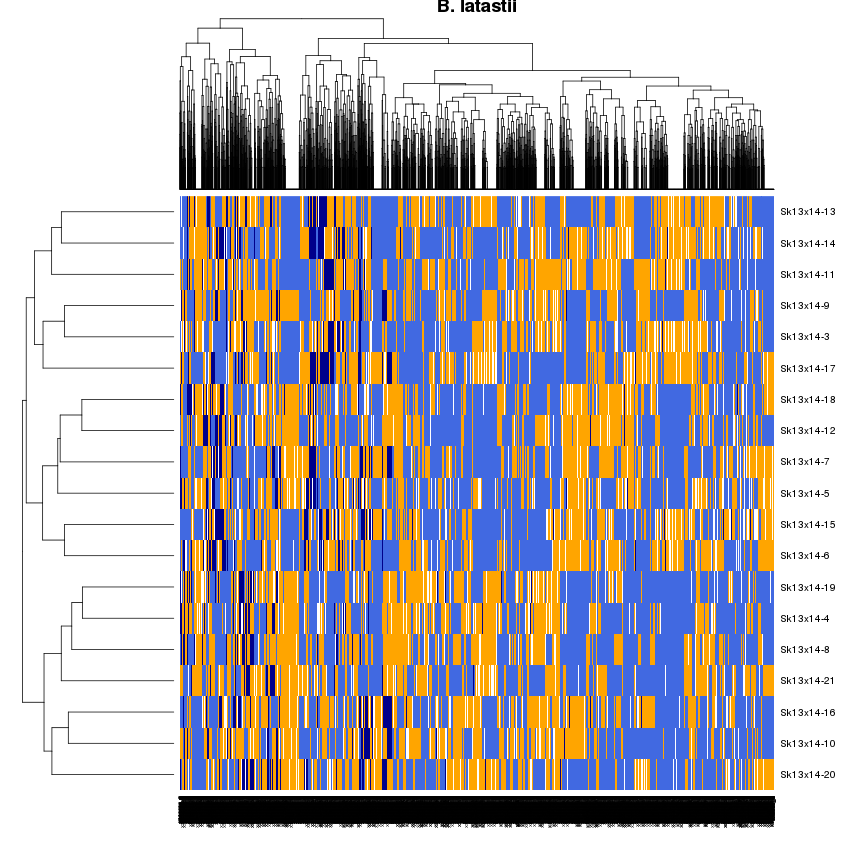

In [275]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/STOECK/Bufo_latastii/Populations_latastii/batch_1_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "B. latastii")

## Validation of the sex-blind method using R. arvalis. . . 

So I need to try to validate this method using a dataset that we already know the answer for. We do have some samples from R. temporaria from the south of Sweden - they are meant to have homomorphic sex chromosomes but we still know that they use Chr01 and DMRT1 markers are linked. 

So I can try the sex-blind approach using this family.



In [389]:
import vcf

Male = "ST01_M_all"
Female = "ST01_F_all"


vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01/batch_1.vcf.altered"

myVCF = vcf.Reader(open(vcf_path, 'r'))

locus_counter = 0
SL_locus_counter = 0 

whitelist = []

for record in myVCF:
    locus_counter += 1
    
    het_het = False
    hom_hom = False

    for sample in record.samples:
        
        if sample.sample == Female: ## for the heterogametic genotype at this locus
            if sample.is_het: 
                het_het = True

    if het_het == True:
        for sample in record.samples:

            if sample.sample == Male: ## for the homogametic genotype at this locus
            
                if sample['GT'] == "1/1" or sample['GT'] == "0/0": 
                    hom_hom = True
                    

    if all([het_het == True, hom_hom == True]):
        
        
        whitelist.append(record.ID)
        
        SL_locus_counter += 1

print locus_counter, SL_locus_counter
    



22331 7315


In [392]:
MISC.filter_vcf_tag_ID_only(vcf_path, whitelist, "batch_1_filtered_loci_ZW_sexblind.vcf")

In [393]:
%%bash

wd=/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01/  ## just change this line

sed 's/_/-/g' $wd/batch_1_filtered_loci_ZW_sexblind.vcf > $wd/batch_1_filtered_loci_ZW_sexblind_altered.vcf ## alter for adegenet

## All data 
/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_filtered_loci_ZW_sexblind_altered.vcf --recode A --allow-extra-chr -out $wd/batch_1_filtered_loci_ZW_sexblind_altered_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01//batch_1_filtered_loci_ZW_sexblind_altered_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01//batch_1_filtered_loci_ZW_sexblind_altered_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01//batch_1_filtered_loci_ZW_sexblind_altered.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01//batch_1_filtered_loci_ZW_sexblind_altered_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01//batch_1_filtered_loci_ZW_sexblind_altered_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01//batch_1_filtered_loci_ZW_sexblind_altered_plink-temporary.fam
written.
8214 

In [394]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01/") 

## All SNPs (about 80,000)
Blat <- read.PLINK('batch_1_filtered_loci_ZW_sexblind_altered_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca8 <- glPca(Blat, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



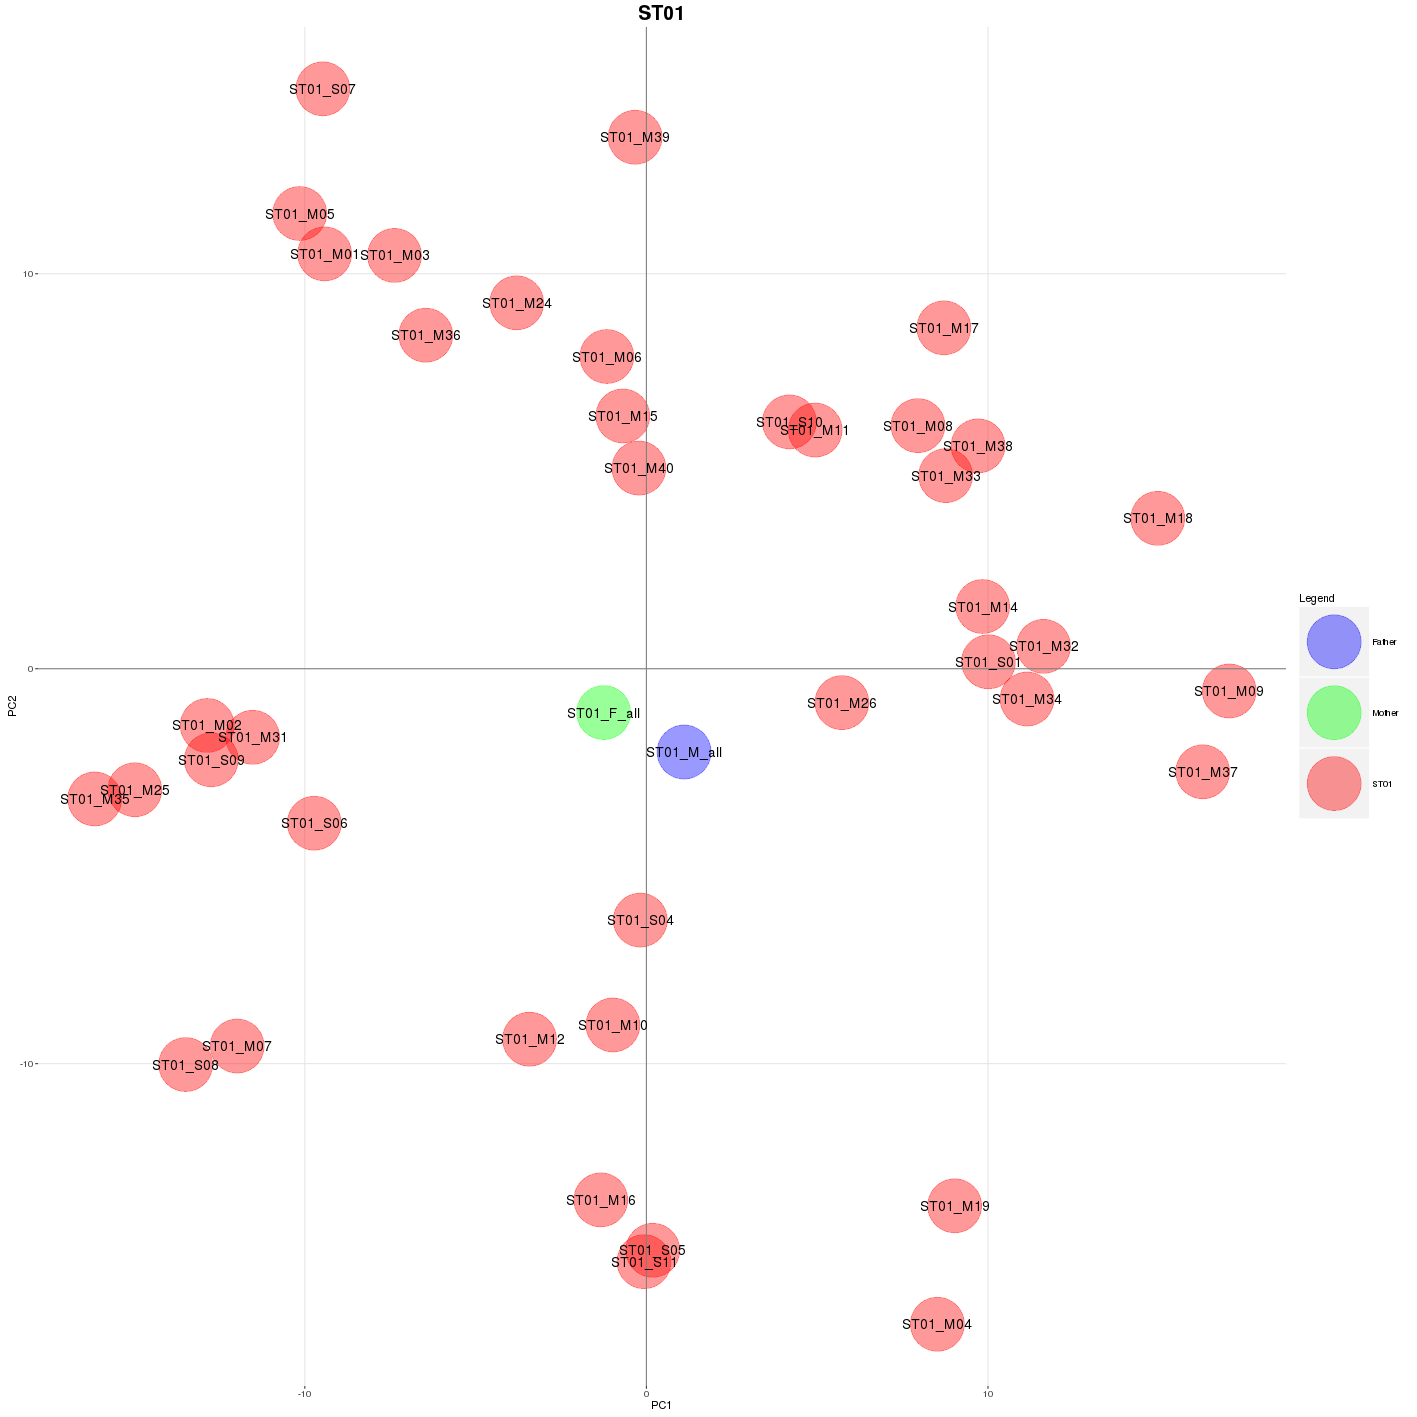

In [386]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_ST01.txt", header = F)

Sex_sorter(pca8,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "ST01", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = c("blue", "green", "red", "black"),            #Palette = rainbow(10), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

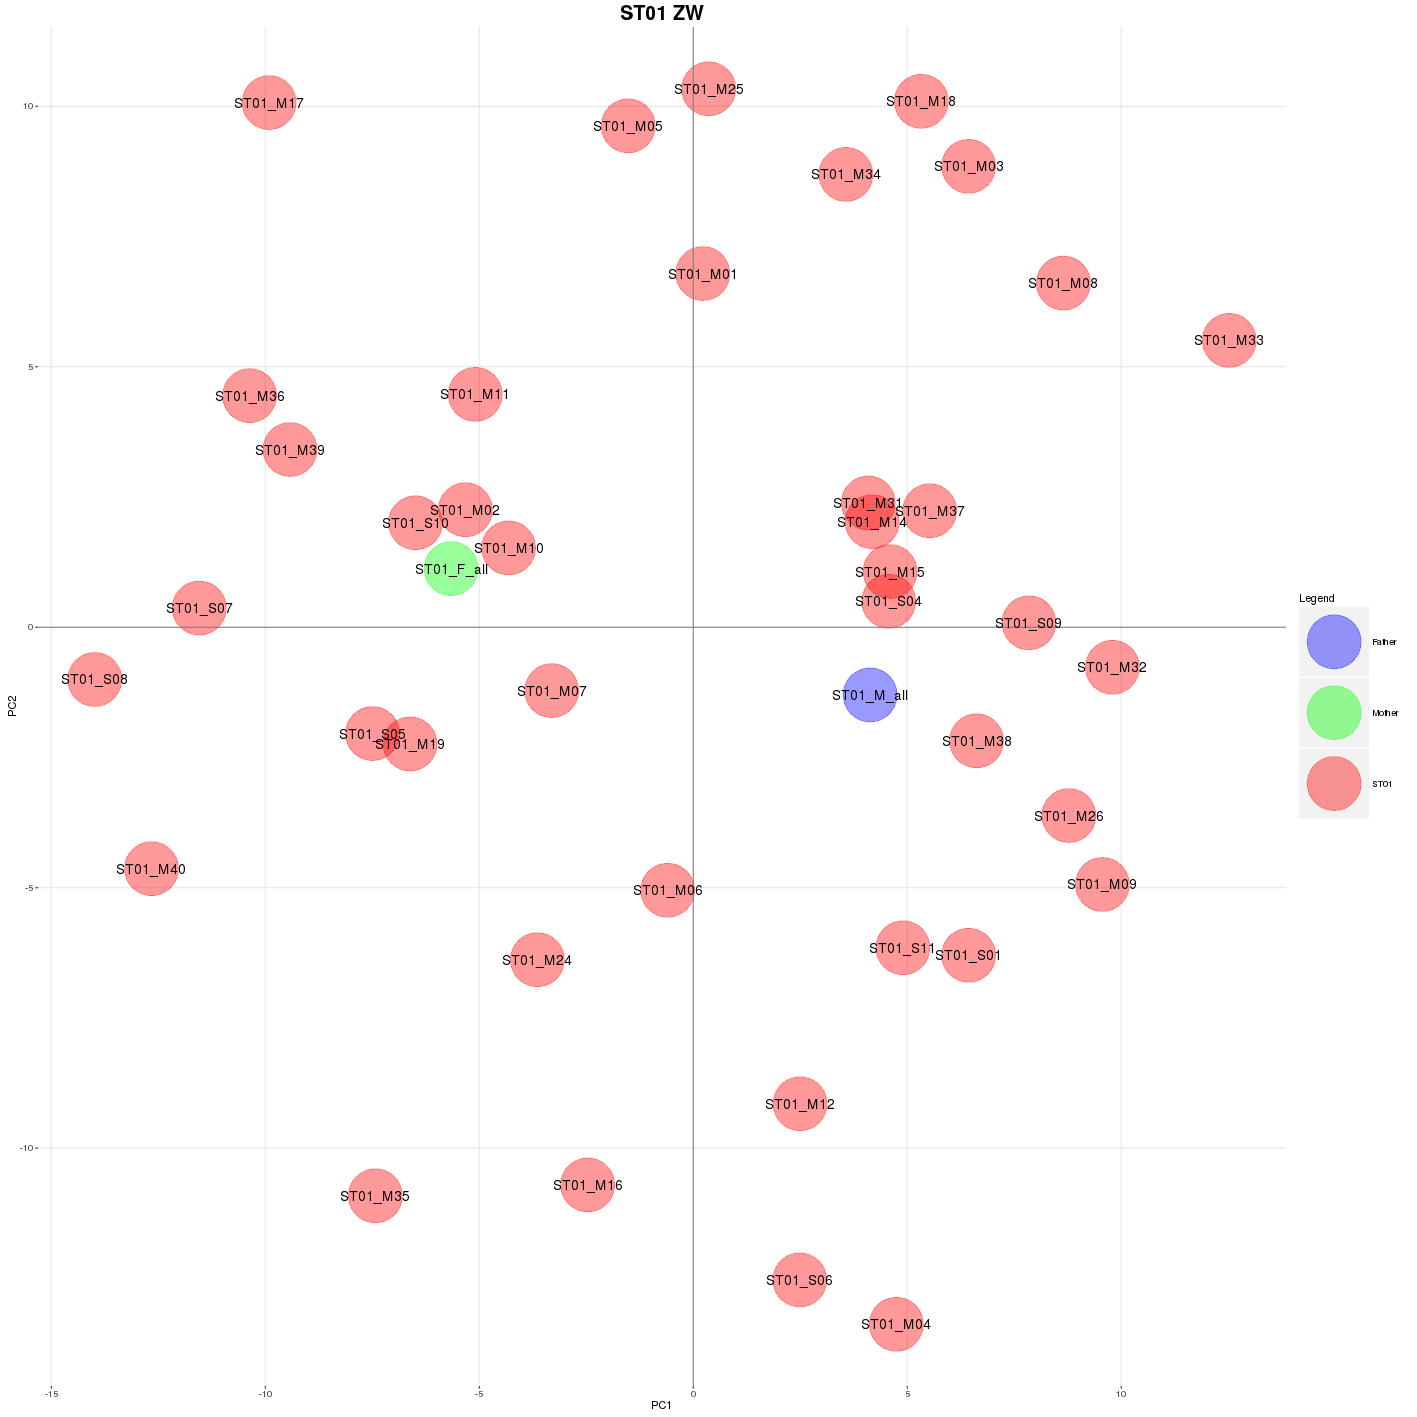

In [395]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_ST01.txt", header = F)

Sex_sorter(pca8,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "ST01 ZW", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = c("blue", "green", "red", "black"),            #Palette = rainbow(10), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [397]:
%%bash

wd=/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01/

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_filtered_loci_ZW_sexblind_altered_plink.raw  $wd/batch_1_filtered_loci_ZW_sexblind_heatmap_input


## XY

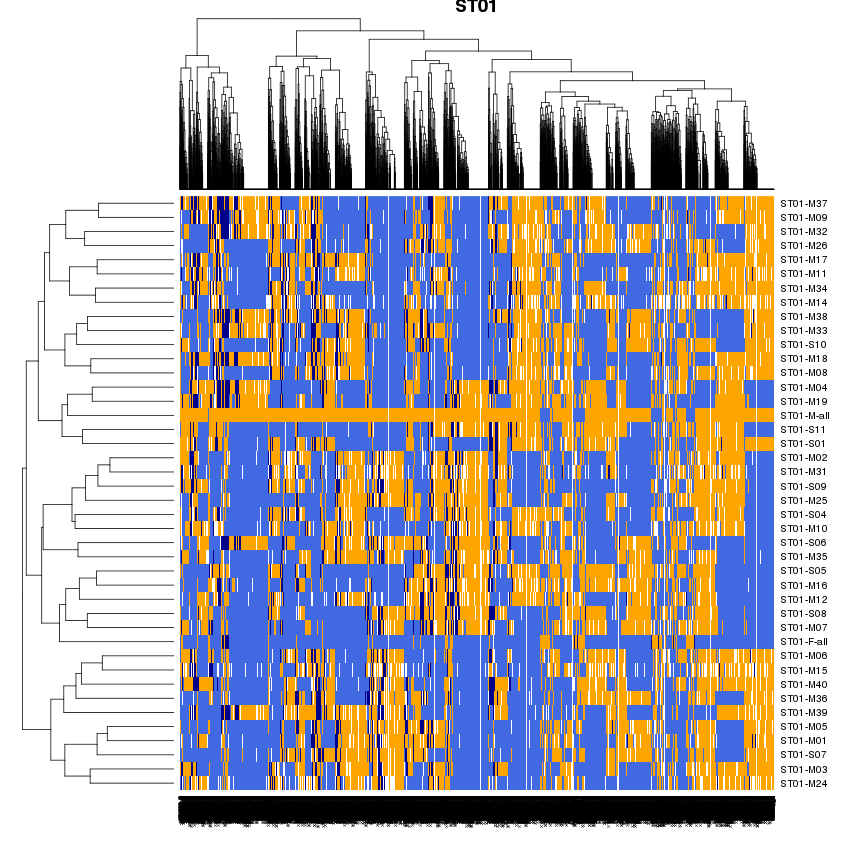

In [388]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01/batch_1_filtered_loci_XY_sexblind_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "ST01")

## ZW

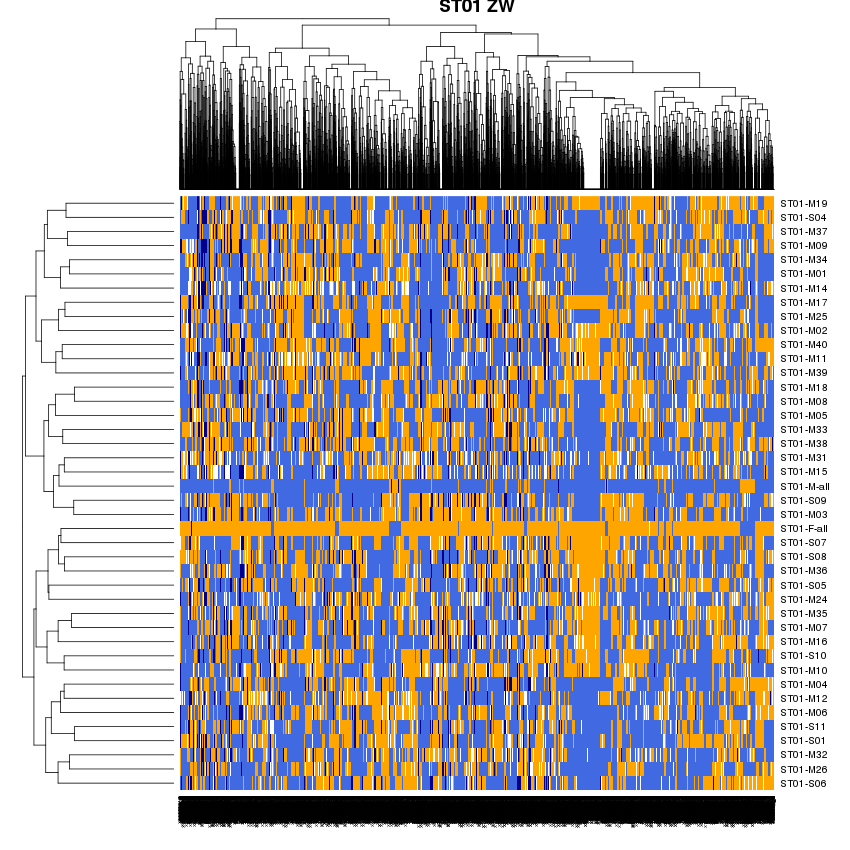

In [398]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/R_temp_fams/Populations_ST01/batch_1_filtered_loci_ZW_sexblind_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "ST01 ZW")